### Color struc, Edge histo

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.84      0.94      0.89       606
    Infected       0.94      0.82      0.87       601

    accuracy                           0.88      1207
   macro avg       0.89      0.88      0.88      1207
weighted avg       0.89      0.88      0.88      1207

Confusion Matrix for Validation Data:


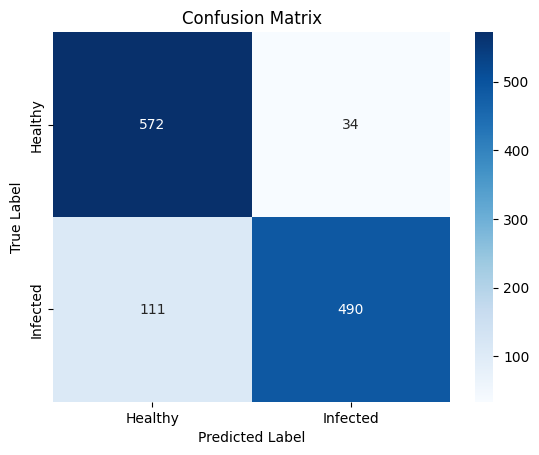

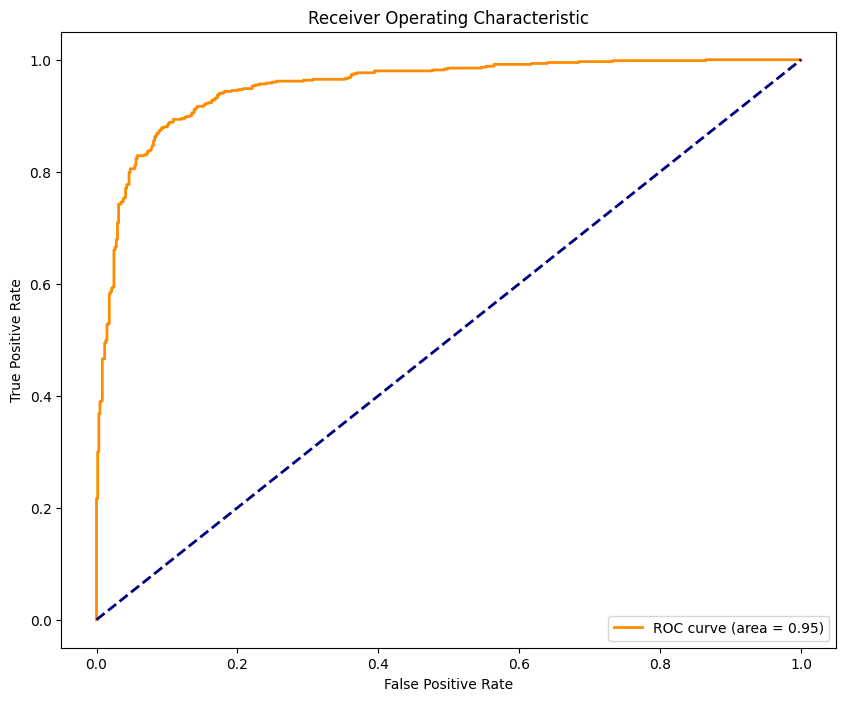

In [3]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract features and load data
def extract_features_and_load_data(directory, img_height, img_width):
    images = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                features = extract_combined_features(img_array)
                images.append(features)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

# Feature extraction functions
def extract_color_structure(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_edge_histogram(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    hist = cv2.calcHist([edges], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_piv(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    piv = np.var(gray_image)
    return piv

def extract_combined_features(image):
    color_structure = extract_color_structure(image)
    edge_histogram = extract_edge_histogram(image)
    combined_features = np.hstack([color_structure, edge_histogram])
    return combined_features

# Load and process data
X_train, y_train, class_names = extract_features_and_load_data(train_dir, img_height, img_width)
X_val, y_val, _ = extract_features_and_load_data(validation_dir, img_height, img_width)
X_test, y_test, _ = extract_features_and_load_data(test_dir, img_height, img_width)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)

# Validation predictions
y_val_pred = svm.predict(X_val)
y_val_prob = svm.predict_proba(X_val)[:, 1]

# Classification report and confusion matrix
print('Classification Report for Validation Data:')
print(classification_report(y_val, y_val_pred, target_names=class_names))
print('Confusion Matrix for Validation Data:')
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
lb = LabelBinarizer()
y_val_binarized = lb.fit_transform(y_val).ravel()
fpr, tpr, _ = roc_curve(y_val_binarized, y_val_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.85      0.91      0.88       299
    Infected       0.90      0.83      0.87       289

    accuracy                           0.87       588
   macro avg       0.87      0.87      0.87       588
weighted avg       0.87      0.87      0.87       588

Confusion Matrix for Test Data:


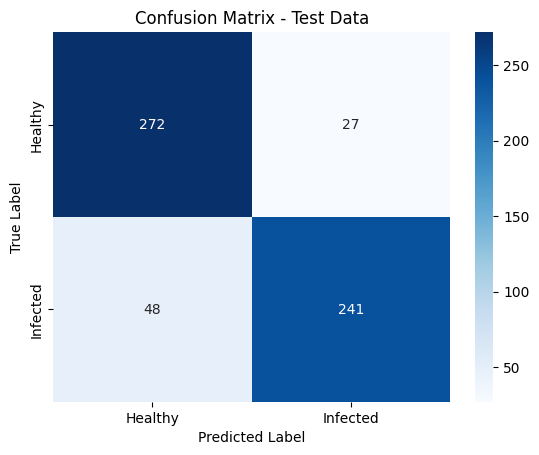

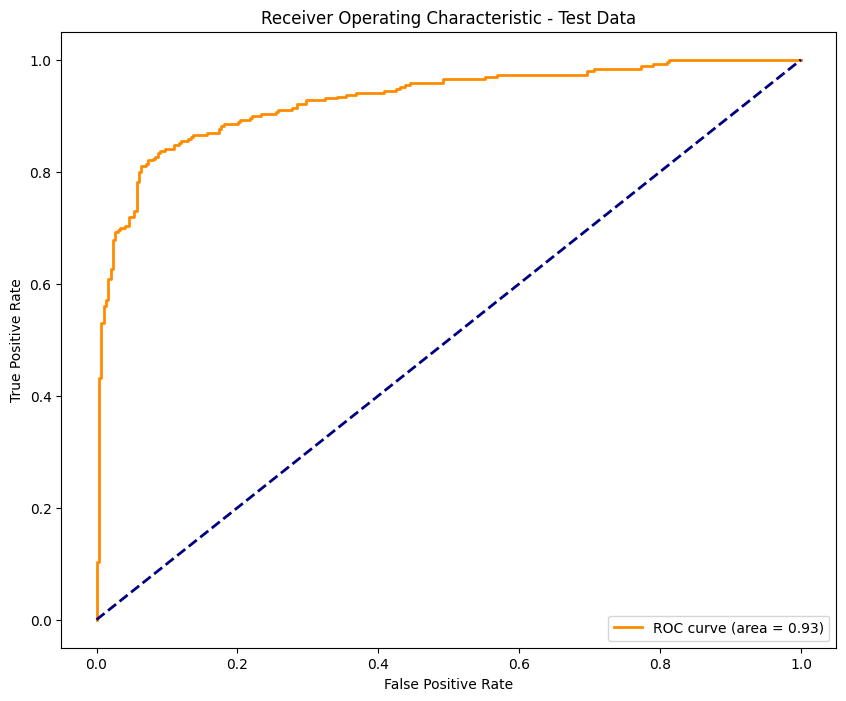

In [4]:
# Test predictions
y_test_pred = svm.predict(X_test)
y_test_prob = svm.predict_proba(X_test)[:, 1]

# Classification report and confusion matrix for Test Data
print('Classification Report for Test Data:')
print(classification_report(y_test, y_test_pred, target_names=class_names))
print('Confusion Matrix for Test Data:')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC for Test Data
lb_test = LabelBinarizer()
y_test_binarized = lb_test.fit_transform(y_test).ravel()
fpr_test, tpr_test, _ = roc_curve(y_test_binarized, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Data')
plt.legend(loc="lower right")
plt.show()


### color struc, Edge histo, PIV

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.84      0.94      0.89       606
    Infected       0.93      0.81      0.87       601

    accuracy                           0.88      1207
   macro avg       0.89      0.88      0.88      1207
weighted avg       0.89      0.88      0.88      1207

Confusion Matrix for Validation Data:


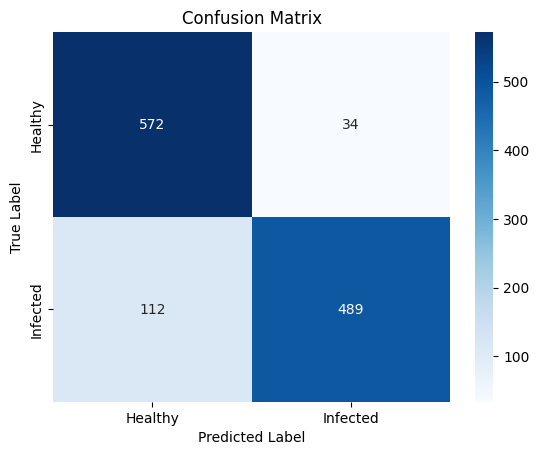

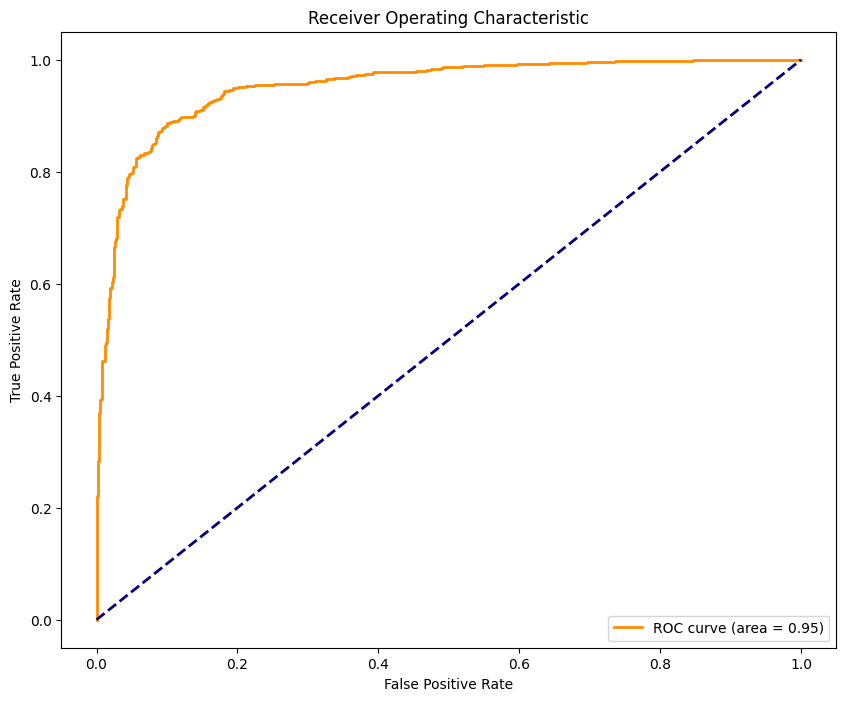

In [2]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract features and load data
def extract_features_and_load_data(directory, img_height, img_width):
    images = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                features = extract_combined_features(img_array)
                images.append(features)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

# Feature extraction functions
def extract_color_structure(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_edge_histogram(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    hist = cv2.calcHist([edges], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_piv(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    piv = np.var(gray_image)
    return piv

def extract_combined_features(image):
    color_structure = extract_color_structure(image)
    edge_histogram = extract_edge_histogram(image)
    piv = extract_piv(image)
    combined_features = np.hstack([color_structure, edge_histogram, piv])
    return combined_features

# Load and process data
X_train, y_train, class_names = extract_features_and_load_data(train_dir, img_height, img_width)
X_val, y_val, _ = extract_features_and_load_data(validation_dir, img_height, img_width)
X_test, y_test, _ = extract_features_and_load_data(test_dir, img_height, img_width)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)

# Validation predictions
y_val_pred = svm.predict(X_val)
y_val_prob = svm.predict_proba(X_val)[:, 1]

# Classification report and confusion matrix
print('Classification Report for Validation Data:')
print(classification_report(y_val, y_val_pred, target_names=class_names))
print('Confusion Matrix for Validation Data:')
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
lb = LabelBinarizer()
y_val_binarized = lb.fit_transform(y_val).ravel()
fpr, tpr, _ = roc_curve(y_val_binarized, y_val_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 65mins


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.86      0.91      0.88       299
    Infected       0.90      0.84      0.87       289

    accuracy                           0.88       588
   macro avg       0.88      0.88      0.88       588
weighted avg       0.88      0.88      0.88       588

Confusion Matrix for Test Data:


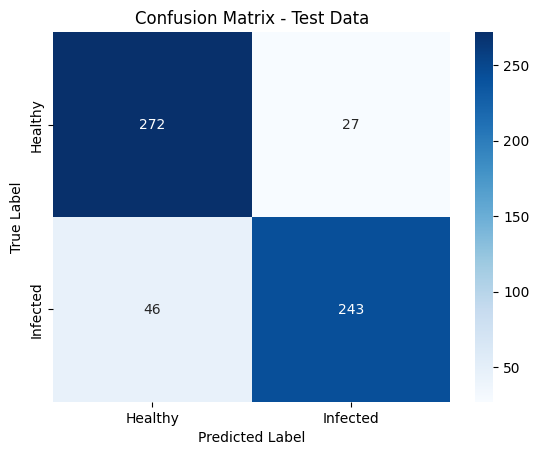

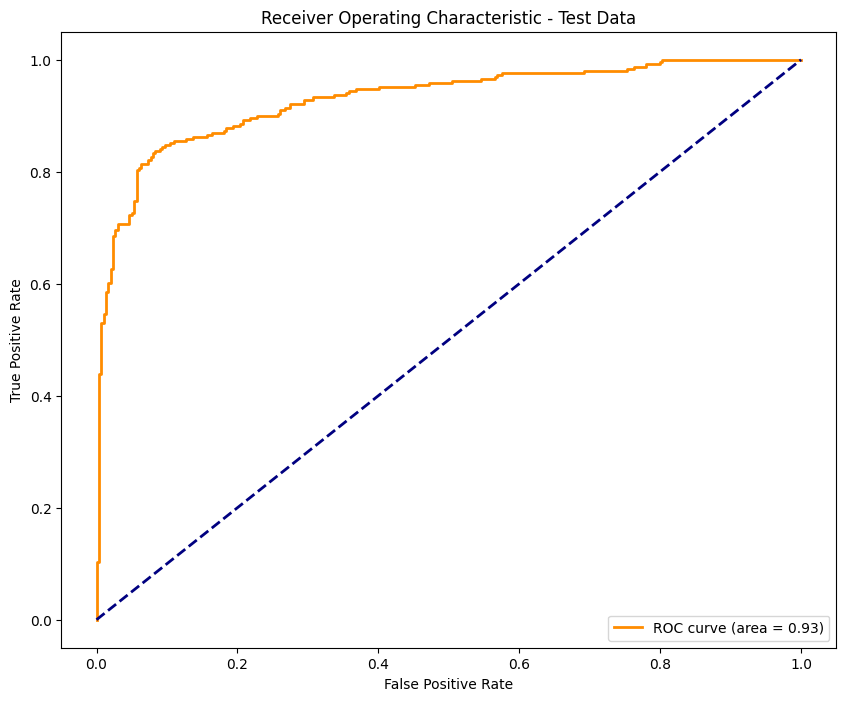

In [3]:
# Test predictions
y_test_pred = svm.predict(X_test)
y_test_prob = svm.predict_proba(X_test)[:, 1]

# Classification report and confusion matrix for Test Data
print('Classification Report for Test Data:')
print(classification_report(y_test, y_test_pred, target_names=class_names))
print('Confusion Matrix for Test Data:')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC for Test Data
lb_test = LabelBinarizer()
y_test_binarized = lb_test.fit_transform(y_test).ravel()
fpr_test, tpr_test, _ = roc_curve(y_test_binarized, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Data')
plt.legend(loc="lower right")
plt.show()


### Color struct, Coor moment, Color layout

Extracting features from training data...
Training data: (28933, 713), Labels: (28933,)
Extracting features from validation data...
Validation data: (1207, 713), Labels: (1207,)
Extracting features from test data...
Test data: (588, 713), Labels: (588,)
Normalizing features...
Training Support Vector Machine (SVM) classifier...
SVM training completed.
Predicting on validation data...
Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.85      0.94      0.89       606
    Infected       0.93      0.84      0.88       601

    accuracy                           0.89      1207
   macro avg       0.89      0.89      0.89      1207
weighted avg       0.89      0.89      0.89      1207

Confusion Matrix for Validation Data:


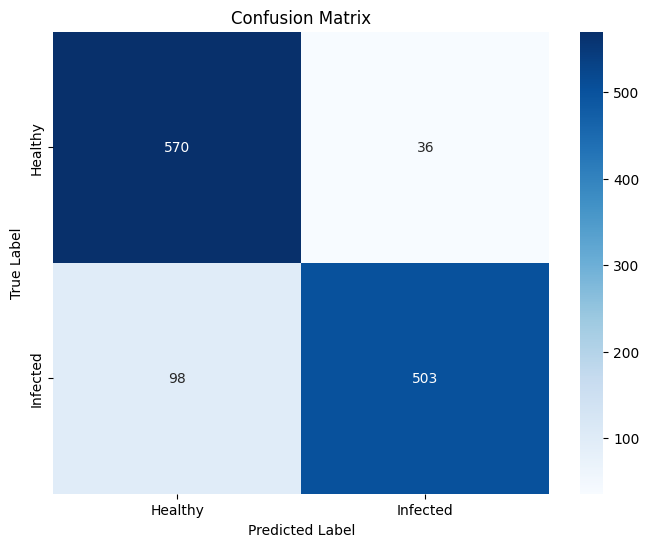

Generating ROC Curve and calculating AUC...


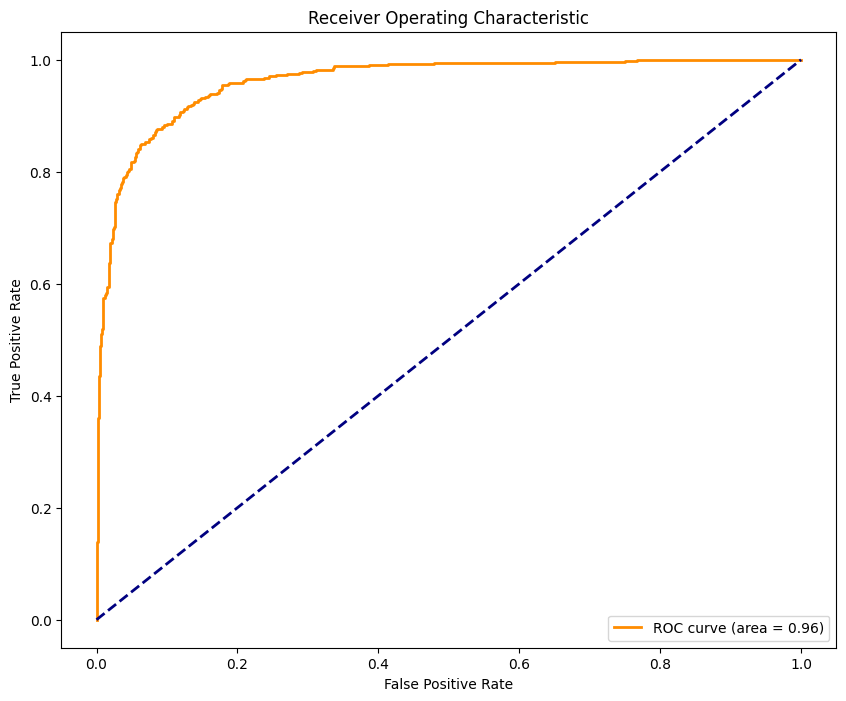

Evaluating on test data...
Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.74      0.94      0.83       299
    Infected       0.91      0.67      0.77       289

    accuracy                           0.80       588
   macro avg       0.83      0.80      0.80       588
weighted avg       0.83      0.80      0.80       588

Confusion Matrix for Test Data:


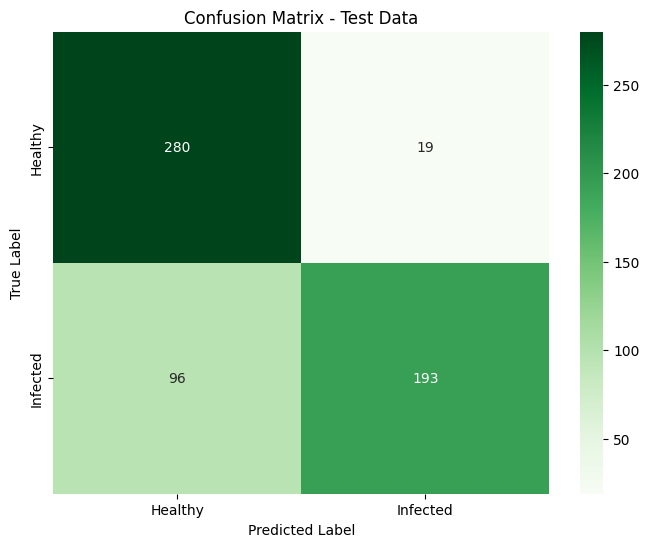

Generating ROC Curve and calculating AUC...


NameError: name 'y_test_binarized' is not defined

In [1]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Feature extraction functions

# Feature extraction function: Color Structure
def extract_color_structure(image, bins=(8, 8, 8)):
    """
    Extract color structure features by computing a 3D color histogram
    in the RGB color space and normalizing it.
    
    Parameters:
    - image: Input image in RGB format.
    - bins: Tuple specifying the number of bins for each channel.
    
    Returns:
    - hist: Flattened and normalized histogram as a 1D array.
    """
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Feature extraction function: Color Moments
def extract_color_moments(image):
    """
    Extract color moments (mean, standard deviation, skewness) from the image
    in HSV color space.
    
    Parameters:
    - image: Input image in RGB format.
    
    Returns:
    - moments: 1D array containing color moments for each HSV channel.
    """
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV)
    # Split channels
    channels = cv2.split(hsv_image)
    moments = []
    for channel in channels:
        # Flatten the channel
        channel = channel.flatten()
        # Calculate moments
        mean = np.mean(channel)
        std = np.std(channel)
        sk = skew(channel)
        moments.extend([mean, std, sk])
    return np.array(moments)

# Feature extraction function: Color Layout Descriptor
def extract_color_layout(image, grid_size=(8, 8)):
    """
    Extract color layout descriptor by dividing the image into a grid
    and computing the YCbCr color channels for each grid cell.
    
    Parameters:
    - image: Input image in RGB format.
    - grid_size: Tuple specifying the number of grid cells along height and width.
    
    Returns:
    - features: Flattened array of YCbCr values for each grid cell.
    """
    h, w, _ = image.shape
    grid_h, grid_w = grid_size
    features = []
    # Resize image to match grid size
    resized = cv2.resize(image, (grid_w, grid_h))
    # Convert to YCbCr color space
    ycbcr_image = cv2.cvtColor(resized, cv2.COLOR_RGB2YCrCb)
    # Flatten channels
    for i in range(3):  # Y, Cr, Cb
        channel = ycbcr_image[:, :, i]
        features.extend(channel.flatten())
    return np.array(features)

# Combined feature extraction function using the new descriptors
def extract_combined_features(image):
    """
    Combine Color Structure, Color Moments, and Color Layout Descriptor features.
    
    Parameters:
    - image: Input image in RGB format.
    
    Returns:
    - combined_features: 1D array containing all combined features.
    """
    color_structure = extract_color_structure(image)
    color_moments = extract_color_moments(image)
    color_layout = extract_color_layout(image)
    combined_features = np.hstack([color_structure, color_moments, color_layout])
    return combined_features

# Function to extract features and load data
def extract_features_and_load_data(directory, img_height, img_width):
    """
    Load images from the specified directory, extract features using the combined
    feature extraction function, and return the feature matrix and labels.
    
    Parameters:
    - directory: Path to the dataset directory.
    - img_height: Target image height.
    - img_width: Target image width.
    
    Returns:
    - images: Numpy array of extracted features.
    - labels: Numpy array of corresponding labels.
    - class_names: List of class names.
    """
    images = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.exists(class_path):
            print(f"Directory {class_path} does not exist. Skipping.")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                features = extract_combined_features(img_array)
                images.append(features)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

# Load and process data
print("Extracting features from training data...")
X_train, y_train, class_names = extract_features_and_load_data(train_dir, img_height, img_width)
print(f"Training data: {X_train.shape}, Labels: {y_train.shape}")

print("Extracting features from validation data...")
X_val, y_val, _ = extract_features_and_load_data(validation_dir, img_height, img_width)
print(f"Validation data: {X_val.shape}, Labels: {y_val.shape}")

print("Extracting features from test data...")
X_test, y_test, _ = extract_features_and_load_data(test_dir, img_height, img_width)
print(f"Test data: {X_test.shape}, Labels: {y_test.shape}")

# Normalize features
print("Normalizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training Support Vector Machine (SVM) classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("SVM training completed.")

# Validation predictions
print("Predicting on validation data...")
y_val_pred = svm.predict(X_val)
y_val_prob = svm.predict_proba(X_val)[:, 1]

# Classification report and confusion matrix
print('Classification Report for Validation Data:')
print(classification_report(y_val, y_val_pred, target_names=class_names))

print('Confusion Matrix for Validation Data:')
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
print("Generating ROC Curve and calculating AUC...")
lb = LabelBinarizer()
y_val_binarized = lb.fit_transform(y_val).ravel()
fpr, tpr, _ = roc_curve(y_val_binarized, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Additional Evaluation on Test Data (Optional)
print("Evaluating on test data...")
y_test_pred = svm.predict(X_test)
y_test_prob = svm.predict_proba(X_test)[:, 1]

print('Classification Report for Test Data:')
print(classification_report(y_test, y_test_pred, target_names=class_names))

print('Confusion Matrix for Test Data:')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Generating ROC Curve and calculating AUC...


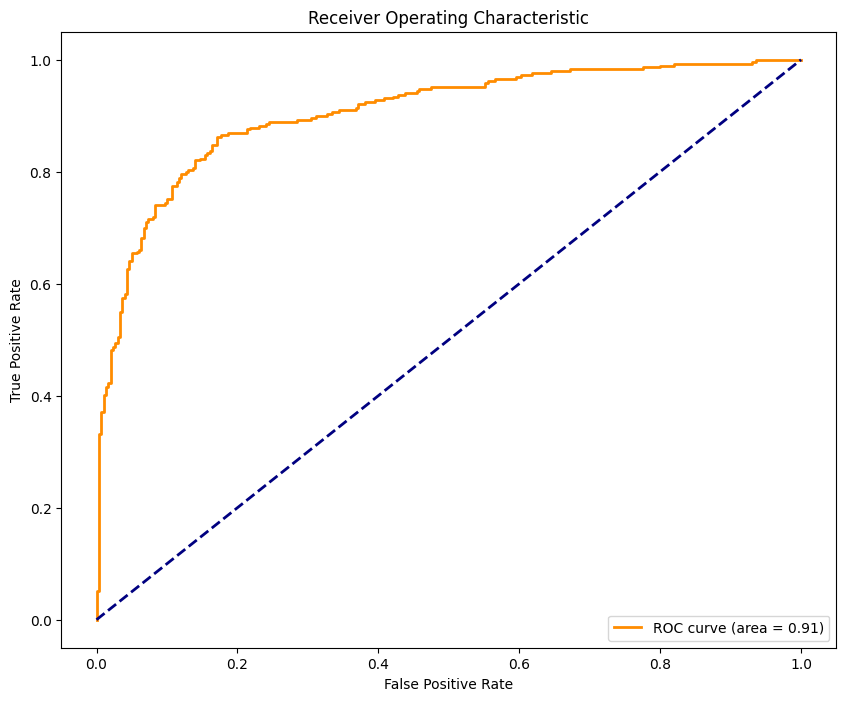

In [2]:
# ROC Curve and AUC
print("Generating ROC Curve and calculating AUC...")
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test).ravel()
fpr, tpr, _ = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Color moments, Dominant Color, Color layout

Extracting features from training data...
Training data: (28933, 210), Labels: (28933,)
Extracting features from validation data...
Validation data: (1207, 210), Labels: (1207,)
Extracting features from test data...
Test data: (588, 210), Labels: (588,)
Normalizing features...
Training Support Vector Machine (SVM) classifier...
SVM training completed.
Predicting on validation data...
Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.82      0.90      0.86       606
    Infected       0.89      0.80      0.84       601

    accuracy                           0.85      1207
   macro avg       0.85      0.85      0.85      1207
weighted avg       0.85      0.85      0.85      1207

Confusion Matrix for Validation Data:


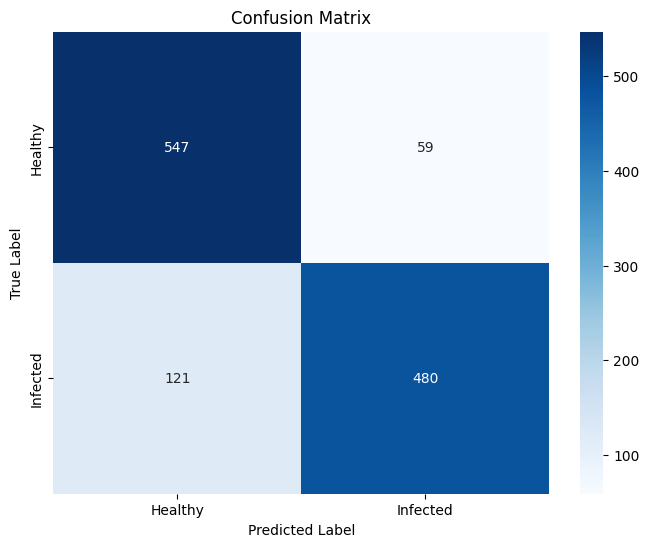

Generating ROC Curve and calculating AUC...


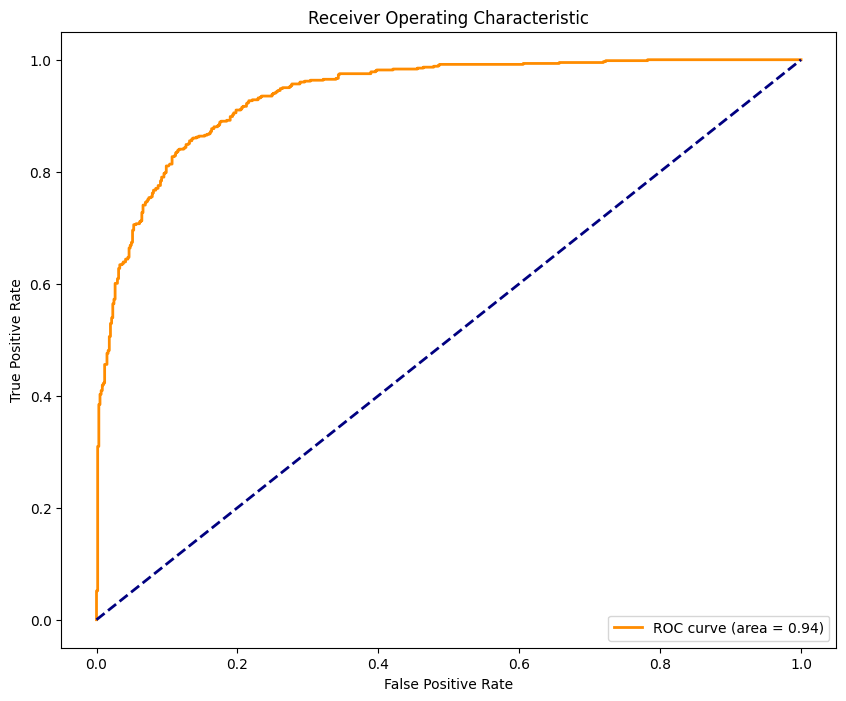

Evaluating on test data...
Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.70      0.95      0.81       299
    Infected       0.92      0.58      0.71       289

    accuracy                           0.77       588
   macro avg       0.81      0.77      0.76       588
weighted avg       0.81      0.77      0.76       588

Confusion Matrix for Test Data:


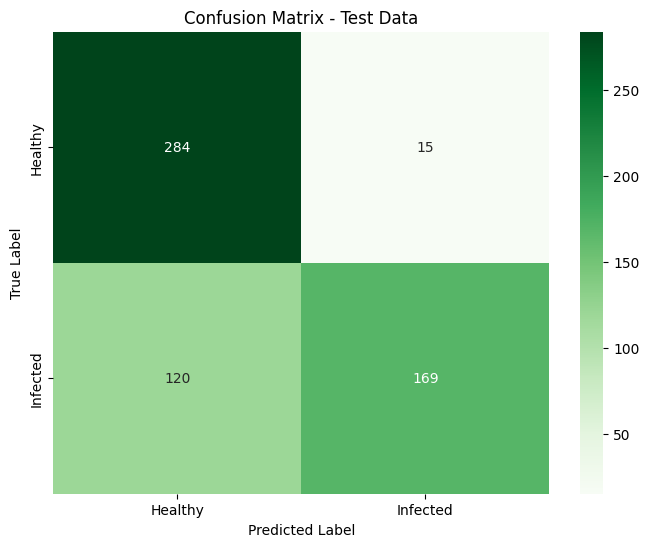

In [2]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.cluster import KMeans

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Feature extraction functions

# Feature extraction function: Color Moments
def extract_color_moments(image):
    """
    Extract color moments from the image in HSV color space.
    Moments include mean, standard deviation, and skewness for each channel.
    """
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV)
    # Split channels
    channels = cv2.split(hsv_image)
    moments = []
    for channel in channels:
        # Flatten the channel
        channel = channel.flatten()
        # Calculate moments
        mean = np.mean(channel)
        std = np.std(channel)
        sk = skew(channel)
        moments.extend([mean, std, sk])
    return np.array(moments)

# Feature extraction function: Dominant Color
def extract_dominant_color(image, num_colors=3):
    """
    Extract dominant colors from the image using KMeans clustering.
    Returns the flattened array of dominant color values.
    """
    # Reshape image to a list of pixels
    pixels = image.reshape(-1, 3)
    # Apply KMeans to find dominant colors
    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    kmeans.fit(pixels)
    # Get cluster centers (dominant colors)
    dominant_colors = kmeans.cluster_centers_.flatten()
    return dominant_colors

# Feature extraction function: Color Layout Descriptor
def extract_color_layout(image, grid_size=(8, 8)):
    """
    Extract color layout descriptor by dividing the image into a grid
    and computing the YCbCr color channels for each grid cell.
    """
    h, w, _ = image.shape
    grid_h, grid_w = grid_size
    features = []
    # Resize image to match grid size
    resized = cv2.resize(image, (grid_w, grid_h))
    # Convert to YCbCr color space
    ycbcr_image = cv2.cvtColor(resized, cv2.COLOR_RGB2YCrCb)
    # Flatten channels
    for i in range(3):  # Y, Cr, Cb
        channel = ycbcr_image[:, :, i]
        features.extend(channel.flatten())
    return np.array(features)

# Combined feature extraction function using the new descriptors
def extract_combined_features_new(image):
    """
    Combine Color Moments, Dominant Color, and Color Layout Descriptor features.
    """
    color_moments = extract_color_moments(image)
    dominant_color = extract_dominant_color(image)
    color_layout = extract_color_layout(image)
    combined_features = np.hstack([color_moments, dominant_color, color_layout])
    return combined_features

# Function to extract features and load data
def extract_features_and_load_data(directory, img_height, img_width):
    """
    Load images from the specified directory, extract features using the combined
    feature extraction function, and return the feature matrix and labels.
    """
    images = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.exists(class_path):
            print(f"Directory {class_path} does not exist. Skipping.")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                features = extract_combined_features_new(img_array)
                images.append(features)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

# Load and process data
print("Extracting features from training data...")
X_train, y_train, class_names = extract_features_and_load_data(train_dir, img_height, img_width)
print(f"Training data: {X_train.shape}, Labels: {y_train.shape}")

print("Extracting features from validation data...")
X_val, y_val, _ = extract_features_and_load_data(validation_dir, img_height, img_width)
print(f"Validation data: {X_val.shape}, Labels: {y_val.shape}")

print("Extracting features from test data...")
X_test, y_test, _ = extract_features_and_load_data(test_dir, img_height, img_width)
print(f"Test data: {X_test.shape}, Labels: {y_test.shape}")

# Normalize features
print("Normalizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training Support Vector Machine (SVM) classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("SVM training completed.")

# Validation predictions
print("Predicting on validation data...")
y_val_pred = svm.predict(X_val)
y_val_prob = svm.predict_proba(X_val)[:, 1]

# Classification report and confusion matrix
print('Classification Report for Validation Data:')
print(classification_report(y_val, y_val_pred, target_names=class_names))

print('Confusion Matrix for Validation Data:')
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
print("Generating ROC Curve and calculating AUC...")
lb = LabelBinarizer()
y_val_binarized = lb.fit_transform(y_val).ravel()
fpr, tpr, _ = roc_curve(y_val_binarized, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Additional Evaluation on Test Data (Optional)
print("Evaluating on test data...")
y_test_pred = svm.predict(X_test)
print('Classification Report for Test Data:')
print(classification_report(y_test, y_test_pred, target_names=class_names))

print('Confusion Matrix for Test Data:')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Generating ROC Curve and calculating AUC...


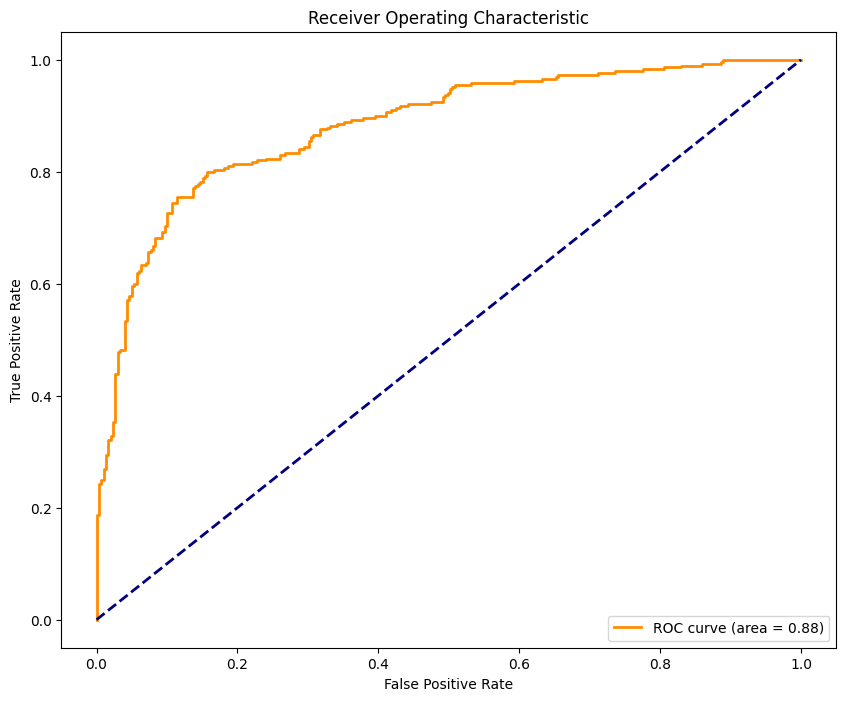

In [6]:
y_test_prob = svm.predict_proba(X_test)[:, 1]

# ROC Curve and AUC
print("Generating ROC Curve and calculating AUC...")
lb = LabelBinarizer()
y_val_binarized = lb.fit_transform(y_test).ravel()
fpr, tpr, _ = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Color structure, edge histo, color moments, color layout

Extracting features from training data...
Training data: (28933, 969), Labels: (28933,)
Extracting features from validation data...
Validation data: (1207, 969), Labels: (1207,)
Extracting features from test data...
Test data: (588, 969), Labels: (588,)
Normalizing features...
Training Support Vector Machine (SVM) classifier...
SVM training completed.
Predicting on validation data...
Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.86      0.94      0.89       606
    Infected       0.93      0.84      0.88       601

    accuracy                           0.89      1207
   macro avg       0.89      0.89      0.89      1207
weighted avg       0.89      0.89      0.89      1207

Confusion Matrix for Validation Data:


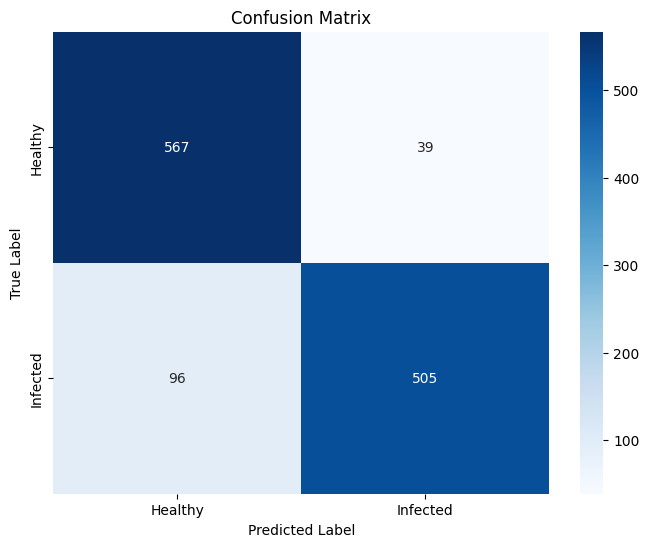

Generating ROC Curve and calculating AUC...


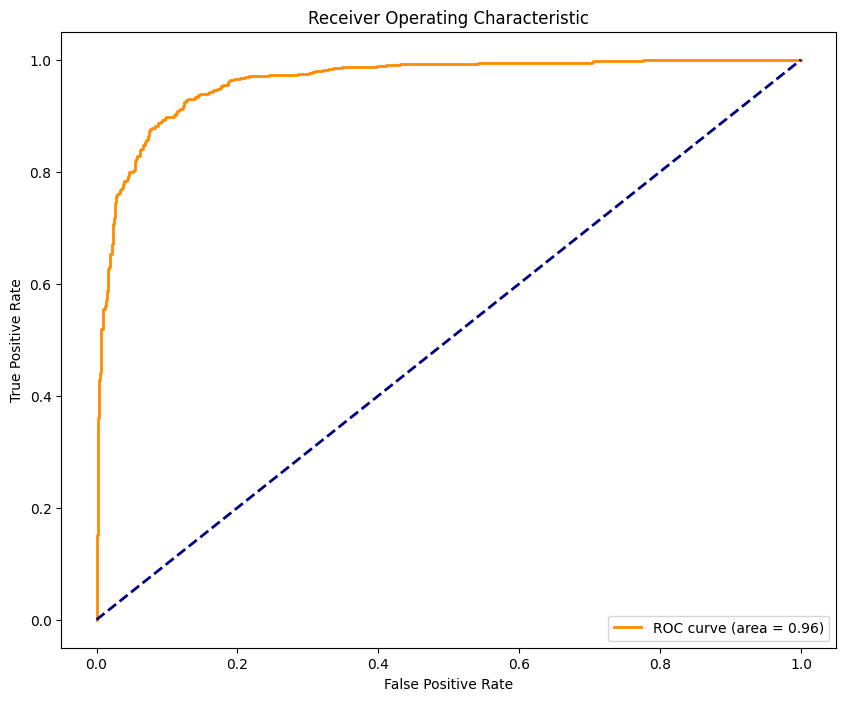

Evaluating on test data...
Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.84      0.91      0.87       299
    Infected       0.90      0.82      0.86       289

    accuracy                           0.87       588
   macro avg       0.87      0.86      0.87       588
weighted avg       0.87      0.87      0.87       588

Confusion Matrix for Test Data:


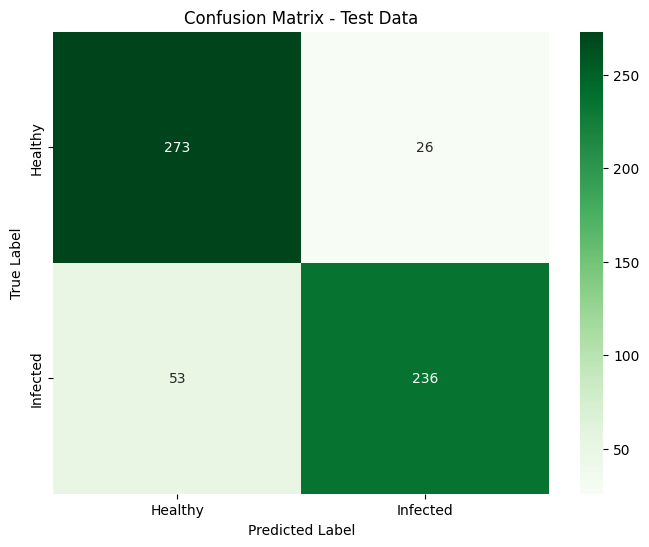

Generating ROC Curve and calculating AUC...


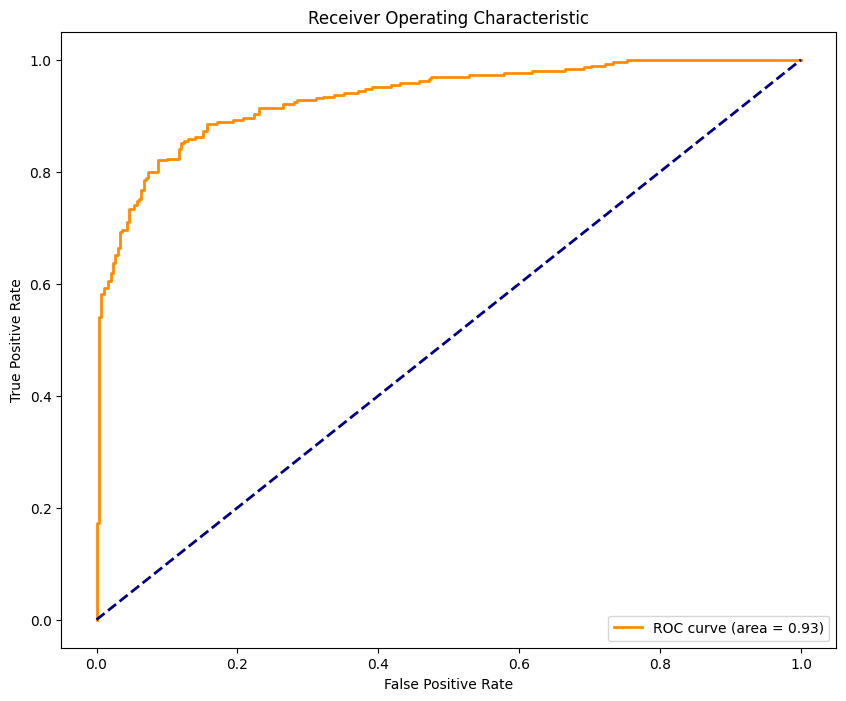

In [3]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract features and load data
def extract_features_and_load_data(directory, img_height, img_width):
    images = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                features = extract_combined_features(img_array)
                images.append(features)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

# Feature extraction functions

# Feature extraction function: Color Structure
def extract_color_structure(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Feature extraction function: Edge Histogram
def extract_edge_histogram(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    hist = cv2.calcHist([edges], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Feature extraction function: Color Layout Descriptor
def extract_color_layout(image, grid_size=(8, 8)):
    h, w, _ = image.shape
    grid_h, grid_w = grid_size
    features = []
    # Resize image to match grid size
    resized = cv2.resize(image, (grid_w, grid_h))
    # Convert to YCbCr color space
    ycbcr_image = cv2.cvtColor(resized, cv2.COLOR_RGB2YCrCb)
    # Flatten channels
    for i in range(3):  # Y, Cr, Cb
        channel = ycbcr_image[:, :, i]
        features.extend(channel.flatten())
    return np.array(features)

# Feature extraction function: Color Moments
def extract_color_moments(image):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV)
    # Split channels
    channels = cv2.split(hsv_image)
    moments = []
    for channel in channels:
        # Flatten the channel
        channel = channel.flatten()
        # Calculate moments
        mean = np.mean(channel)
        std = np.std(channel)
        sk = skew(channel)
        moments.extend([mean, std, sk])
    return np.array(moments)

# Combined feature extraction function using the new descriptors
def extract_combined_features(image):
    color_structure = extract_color_structure(image)
    edge_histogram = extract_edge_histogram(image)
    color_layout = extract_color_layout(image)
    color_moments = extract_color_moments(image)
    combined_features = np.hstack([color_structure, edge_histogram, color_layout, color_moments])
    return combined_features

# Load and process data
print("Extracting features from training data...")
X_train, y_train, class_names = extract_features_and_load_data(train_dir, img_height, img_width)
print(f"Training data: {X_train.shape}, Labels: {y_train.shape}")

print("Extracting features from validation data...")
X_val, y_val, _ = extract_features_and_load_data(validation_dir, img_height, img_width)
print(f"Validation data: {X_val.shape}, Labels: {y_val.shape}")

print("Extracting features from test data...")
X_test, y_test, _ = extract_features_and_load_data(test_dir, img_height, img_width)
print(f"Test data: {X_test.shape}, Labels: {y_test.shape}")

# Normalize features
print("Normalizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training Support Vector Machine (SVM) classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("SVM training completed.")

# Validation predictions
print("Predicting on validation data...")
y_val_pred = svm.predict(X_val)
y_val_prob = svm.predict_proba(X_val)[:, 1]

# Classification report and confusion matrix
print('Classification Report for Validation Data:')
print(classification_report(y_val, y_val_pred, target_names=class_names))

print('Confusion Matrix for Validation Data:')
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
print("Generating ROC Curve and calculating AUC...")
lb = LabelBinarizer()
y_val_binarized = lb.fit_transform(y_val).ravel()
fpr, tpr, _ = roc_curve(y_val_binarized, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


print("Evaluating on test data...")
y_test_pred = svm.predict(X_test)
y_test_prob = svm.predict_proba(X_test)[:, 1]

print('Classification Report for Test Data:')
print(classification_report(y_test, y_test_pred, target_names=class_names))

print('Confusion Matrix for Test Data:')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
print("Generating ROC Curve and calculating AUC...")
lb = LabelBinarizer()
y_val_binarized = lb.fit_transform(y_test).ravel()
fpr, tpr, _ = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Color histo, Color Moments, Dominat color

Extracting features from training data...
Training data: (28933, 530), Labels: (28933,)
Extracting features from validation data...
Validation data: (1207, 530), Labels: (1207,)
Extracting features from test data...
Test data: (588, 530), Labels: (588,)
Normalizing features...
Training Support Vector Machine (SVM) classifier...
SVM training completed.
Predicting on validation data...
Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.85      0.90      0.87       606
    Infected       0.89      0.84      0.86       601

    accuracy                           0.87      1207
   macro avg       0.87      0.87      0.87      1207
weighted avg       0.87      0.87      0.87      1207

Confusion Matrix for Validation Data:


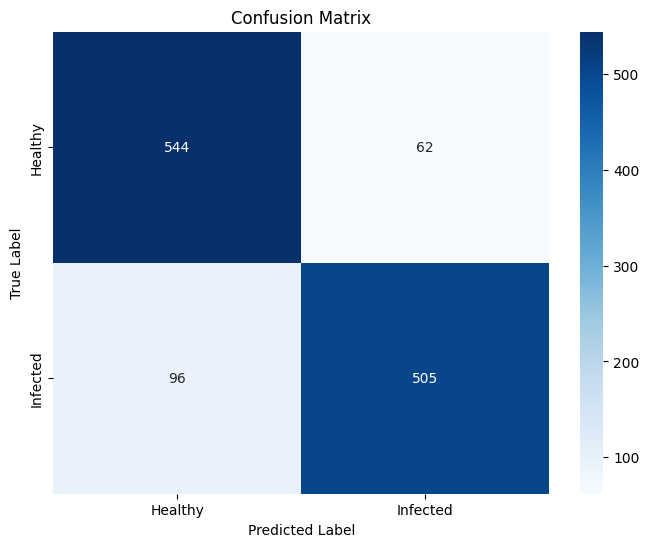

Generating ROC Curve and calculating AUC...


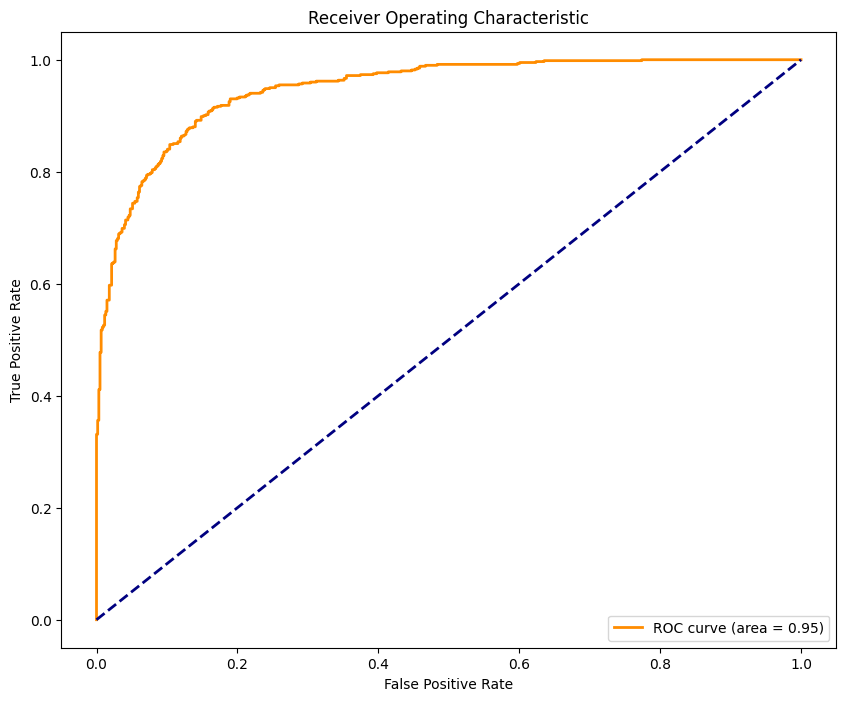

Evaluating on test data...
Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.70      0.75      0.72       299
    Infected       0.72      0.66      0.69       289

    accuracy                           0.71       588
   macro avg       0.71      0.71      0.70       588
weighted avg       0.71      0.71      0.71       588

Confusion Matrix for Test Data:


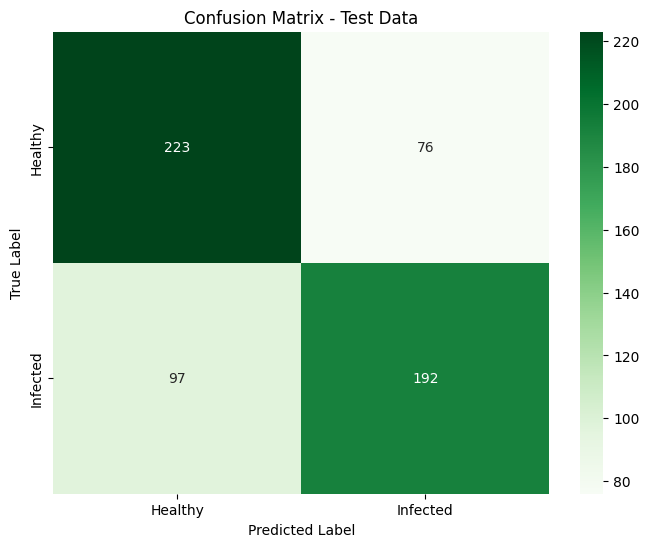

Generating ROC Curve and calculating AUC...


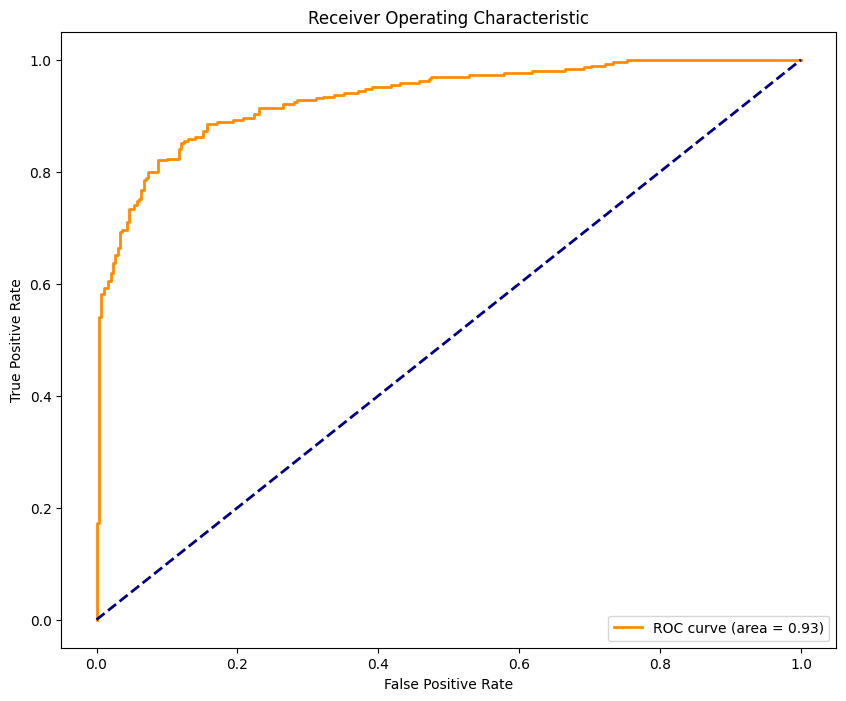

In [5]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Feature extraction functions

# Feature extraction function: Color Histogram
def extract_color_histogram(image, bins=(8, 8, 8)):
    """
    Extract color histogram features by computing a 3D histogram
    in the HSV color space and normalizing it.

    Parameters:
    - image: Input image in RGB format.
    - bins: Tuple specifying the number of bins for each channel.

    Returns:
    - hist: Flattened and normalized histogram as a 1D array.
    """
    hsv_image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Feature extraction function: Color Moments
def extract_color_moments(image):
    """
    Extract color moments (mean, standard deviation, skewness) from the image
    in HSV color space.

    Parameters:
    - image: Input image in RGB format.

    Returns:
    - moments: 1D array containing color moments for each HSV channel.
    """
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV)
    # Split channels
    channels = cv2.split(hsv_image)
    moments = []
    for channel in channels:
        # Flatten the channel
        channel = channel.flatten()
        # Calculate moments
        mean = np.mean(channel)
        std = np.std(channel)
        sk = skew(channel)
        moments.extend([mean, std, sk])
    return np.array(moments)

# Feature extraction function: Dominant Color
def extract_dominant_color(image, num_colors=3):
    """
    Extract dominant colors from the image using KMeans clustering.

    Parameters:
    - image: Input image in RGB format.
    - num_colors: Number of dominant colors to extract.

    Returns:
    - dominant_colors: Flattened array of dominant color values.
    """
    # Reshape image to a list of pixels
    pixels = image.reshape(-1, 3)
    # Apply KMeans to find dominant colors
    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    kmeans.fit(pixels)
    # Get cluster centers (dominant colors)
    dominant_colors = kmeans.cluster_centers_.flatten()
    return dominant_colors

# Combined feature extraction function using the specified descriptors
def extract_combined_features(image):
    """
    Combine Color Histogram, Color Moments, and Dominant Color features.

    Parameters:
    - image: Input image in RGB format.

    Returns:
    - combined_features: 1D array containing all combined features.
    """
    color_histogram = extract_color_histogram(image)
    color_moments = extract_color_moments(image)
    dominant_color = extract_dominant_color(image)
    combined_features = np.hstack([color_histogram, color_moments, dominant_color])
    return combined_features

# Function to extract features and load data
def extract_features_and_load_data(directory, img_height, img_width):
    """
    Load images from the specified directory, extract features using the combined
    feature extraction function, and return the feature matrix and labels.

    Parameters:
    - directory: Path to the dataset directory.
    - img_height: Target image height.
    - img_width: Target image width.

    Returns:
    - images: Numpy array of extracted features.
    - labels: Numpy array of corresponding labels.
    - class_names: List of class names.
    """
    images = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.exists(class_path):
            print(f"Directory {class_path} does not exist. Skipping.")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                features = extract_combined_features(img_array)
                images.append(features)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

# Load and process data
print("Extracting features from training data...")
X_train, y_train, class_names = extract_features_and_load_data(train_dir, img_height, img_width)
print(f"Training data: {X_train.shape}, Labels: {y_train.shape}")

print("Extracting features from validation data...")
X_val, y_val, _ = extract_features_and_load_data(validation_dir, img_height, img_width)
print(f"Validation data: {X_val.shape}, Labels: {y_val.shape}")

print("Extracting features from test data...")
X_test, y_test, _ = extract_features_and_load_data(test_dir, img_height, img_width)
print(f"Test data: {X_test.shape}, Labels: {y_test.shape}")

# Normalize features
print("Normalizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training Support Vector Machine (SVM) classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("SVM training completed.")

# Validation predictions
print("Predicting on validation data...")
y_val_pred = svm.predict(X_val)
y_val_prob = svm.predict_proba(X_val)[:, 1]

# Classification report and confusion matrix
print('Classification Report for Validation Data:')
print(classification_report(y_val, y_val_pred, target_names=class_names))

print('Confusion Matrix for Validation Data:')
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
print("Generating ROC Curve and calculating AUC...")
lb = LabelBinarizer()
y_val_binarized = lb.fit_transform(y_val).ravel()
fpr, tpr, _ = roc_curve(y_val_binarized, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',
         lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Additional Evaluation on Test Data (Optional)
print("Evaluating on test data...")
y_test_pred = svm.predict(X_test)
y_test_binarized = lb.fit_transform(y_test).ravel()
print('Classification Report for Test Data:')
print(classification_report(y_test, y_test_pred, target_names=class_names))

print('Confusion Matrix for Test Data:')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
print("Generating ROC Curve and calculating AUC...")
lb = LabelBinarizer()
fpr, tpr, _ = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Edge histogram

Loading training data...
Training samples: 28933
Feature dimension: 256
Loading validation data...
Validation samples: 1207
Loading test data...
Test samples: 588
Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.59      0.78      0.68       606
    Infected       0.68      0.46      0.55       601

    accuracy                           0.62      1207
   macro avg       0.64      0.62      0.61      1207
weighted avg       0.64      0.62      0.61      1207

Confusion Matrix for Validation Data:


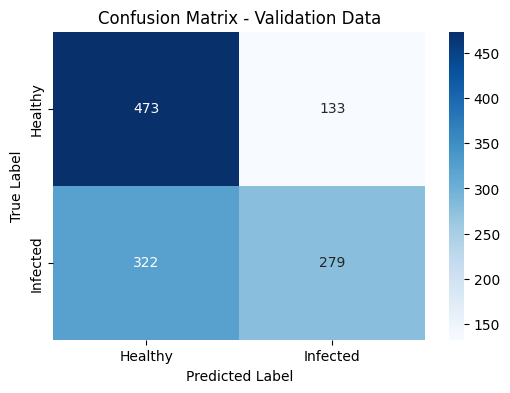

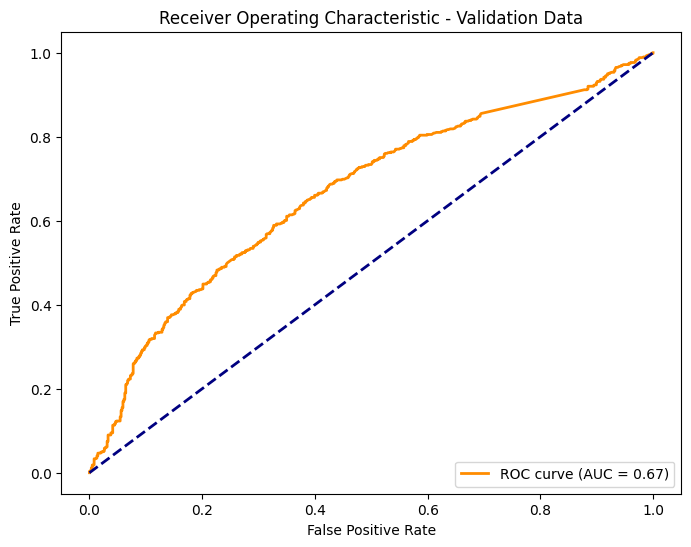


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.77      0.52      0.62       299
    Infected       0.63      0.84      0.72       289

    accuracy                           0.68       588
   macro avg       0.70      0.68      0.67       588
weighted avg       0.70      0.68      0.67       588

Confusion Matrix for Test Data:


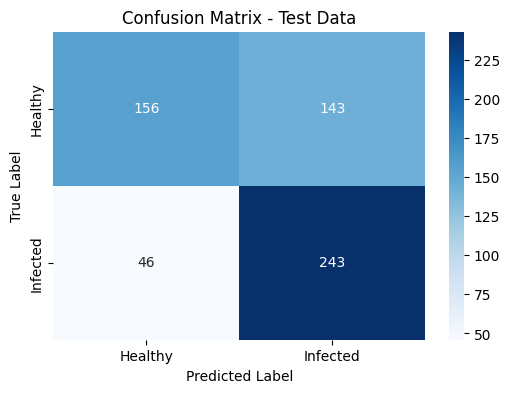

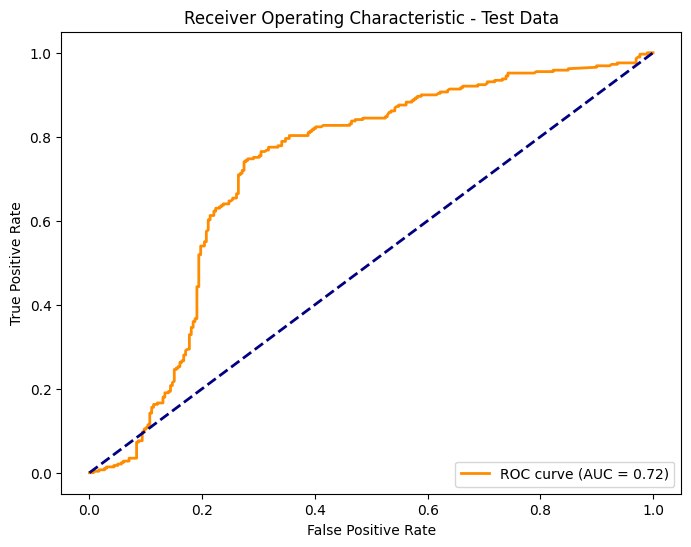

In [1]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract Edge Histogram feature and load data
def extract_edge_histogram_and_load_data(directory, img_height, img_width):
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                edge_hist = extract_edge_histogram(img_array)
                features.append(edge_hist)  # Edge histogram is already a flattened array
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(features), np.array(labels), class_names

# Feature extraction function: Edge Histogram
def extract_edge_histogram(image, bins=256):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    hist = cv2.calcHist([edges], [0], None, [bins], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_edge_histogram_and_load_data(train_dir, img_height, img_width)
print(f"Training samples: {X_train.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

print("Loading validation data...")
X_val, y_val, _ = extract_edge_histogram_and_load_data(validation_dir, img_height, img_width)
print(f"Validation samples: {X_val.shape[0]}")

print("Loading test data...")
X_test, y_test, _ = extract_edge_histogram_and_load_data(test_dir, img_height, img_width)
print(f"Test samples: {X_test.shape[0]}")

# Check if data is loaded
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("One of the datasets is empty. Please check the directory paths and image files.")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Function to evaluate and plot results
def evaluate_model(model, X, y, class_names, dataset_name='Validation'):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    # Classification report
    print(f'\nClassification Report for {dataset_name} Data:')
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion matrix
    print(f'Confusion Matrix for {dataset_name} Data:')
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve and AUC
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()
    fpr, tpr, _ = roc_curve(y_binarized, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name} Data')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### Color structure

Loading training data...
Training samples: 28933
Feature vector size: 512
Loading validation data...
Validation samples: 1207
Feature vector size: 512
Loading test data...
Test samples: 588
Feature vector size: 512
Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.83      0.95      0.89       606
    Infected       0.94      0.81      0.87       601

    accuracy                           0.88      1207
   macro avg       0.88      0.88      0.88      1207
weighted avg       0.88      0.88      0.88      1207

Confusion Matrix for Validation Data:


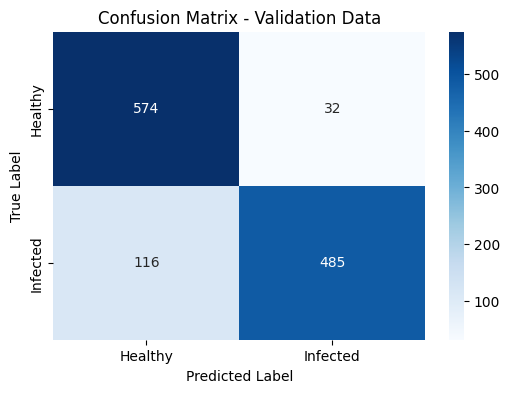

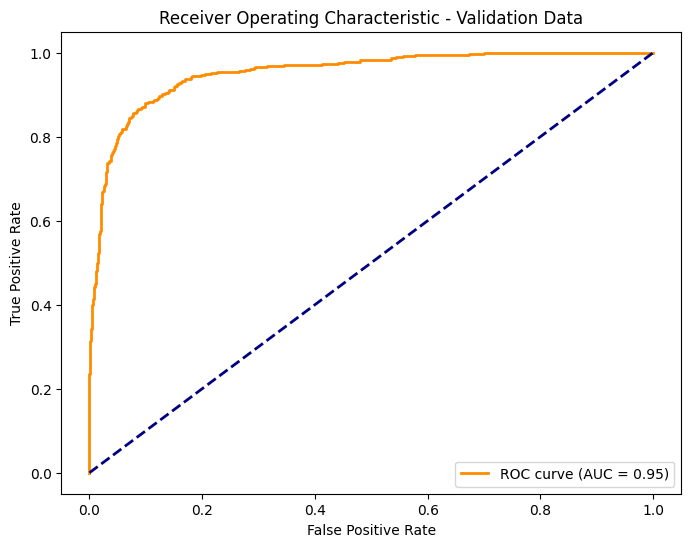


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.74      0.95      0.83       299
    Infected       0.93      0.65      0.76       289

    accuracy                           0.80       588
   macro avg       0.83      0.80      0.80       588
weighted avg       0.83      0.80      0.80       588

Confusion Matrix for Test Data:


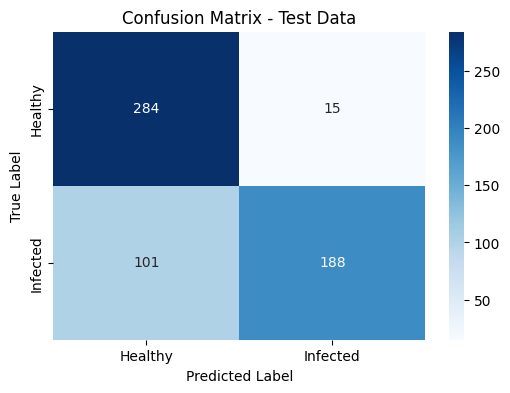

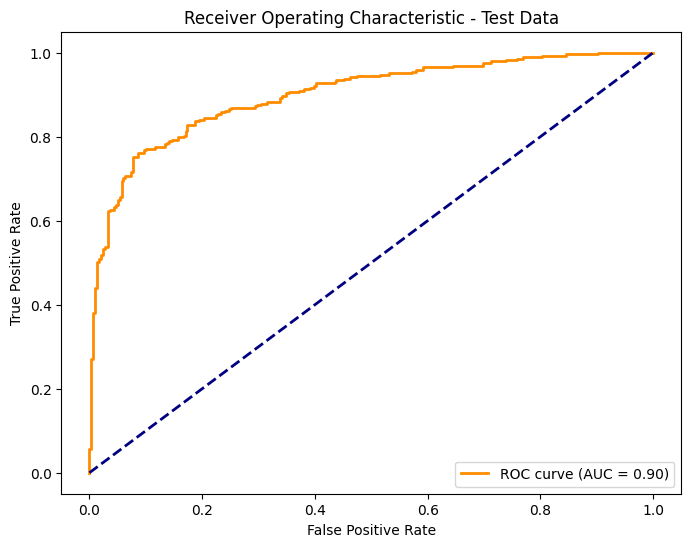

In [1]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Feature extraction function: Color Structure
def extract_color_structure(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Function to extract color structure features and load data
def extract_color_structure_and_load_data(directory, img_height, img_width, bins=(8, 8, 8)):
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                color_structure = extract_color_structure(img_array, bins=bins)
                features.append(color_structure)  # Append the histogram feature vector
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(features), np.array(labels), class_names

# Load and process data using Color Structure features
print("Loading training data...")
X_train, y_train, class_names = extract_color_structure_and_load_data(train_dir, img_height, img_width)
print(f"Training samples: {X_train.shape[0]}")
print(f"Feature vector size: {X_train.shape[1]}")

print("Loading validation data...")
X_val, y_val, _ = extract_color_structure_and_load_data(validation_dir, img_height, img_width)
print(f"Validation samples: {X_val.shape[0]}")
print(f"Feature vector size: {X_val.shape[1]}")

print("Loading test data...")
X_test, y_test, _ = extract_color_structure_and_load_data(test_dir, img_height, img_width)
print(f"Test samples: {X_test.shape[0]}")
print(f"Feature vector size: {X_test.shape[1]}")

# Check if data is loaded
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("One of the datasets is empty. Please check the directory paths and image files.")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Function to evaluate and plot results
def evaluate_model(model, X, y, class_names, dataset_name='Validation'):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    # Classification report
    print(f'\nClassification Report for {dataset_name} Data:')
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion matrix
    print(f'Confusion Matrix for {dataset_name} Data:')
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve and AUC
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()
    fpr, tpr, _ = roc_curve(y_binarized, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name} Data')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### PIV

Loading training data...
Training samples: 28933
Loading validation data...
Validation samples: 1207
Loading test data...
Test samples: 588
Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.61      0.81      0.69       606
    Infected       0.71      0.47      0.57       601

    accuracy                           0.64      1207
   macro avg       0.66      0.64      0.63      1207
weighted avg       0.66      0.64      0.63      1207

Confusion Matrix for Validation Data:


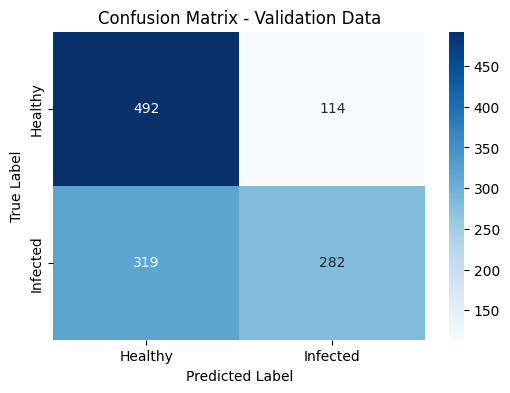

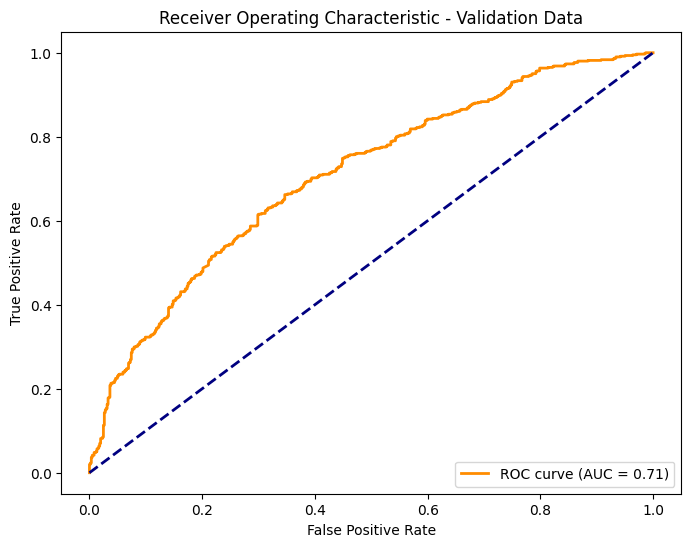


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.55      0.63      0.59       299
    Infected       0.55      0.47      0.51       289

    accuracy                           0.55       588
   macro avg       0.55      0.55      0.55       588
weighted avg       0.55      0.55      0.55       588

Confusion Matrix for Test Data:


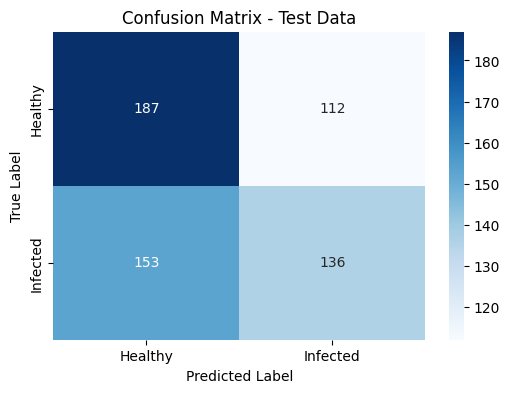

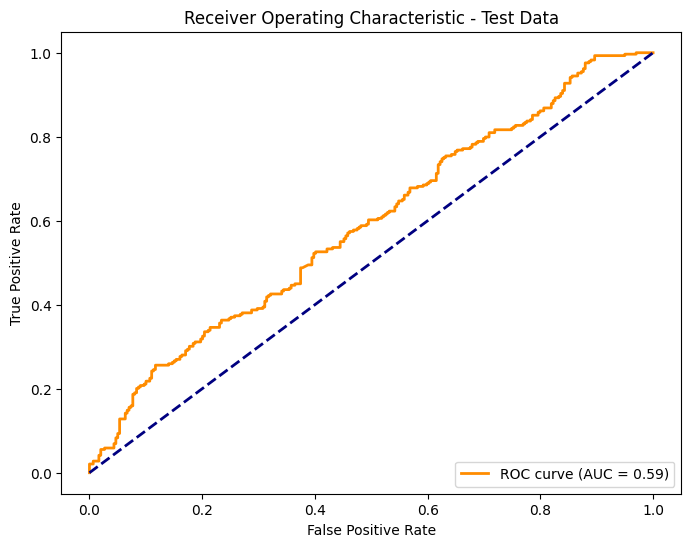

In [2]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract PIV feature and load data
def extract_piv_and_load_data(directory, img_height, img_width):
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                piv = extract_piv(img_array)
                features.append([piv])  # Wrap in a list to maintain 2D shape
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(features), np.array(labels), class_names

# Feature extraction function: PIV (Pixel Intensity Variance)
def extract_piv(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    piv = np.var(gray_image)
    return piv

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_piv_and_load_data(train_dir, img_height, img_width)
print(f"Training samples: {X_train.shape[0]}")

print("Loading validation data...")
X_val, y_val, _ = extract_piv_and_load_data(validation_dir, img_height, img_width)
print(f"Validation samples: {X_val.shape[0]}")

print("Loading test data...")
X_test, y_test, _ = extract_piv_and_load_data(test_dir, img_height, img_width)
print(f"Test samples: {X_test.shape[0]}")

# Check if data is loaded
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("One of the datasets is empty. Please check the directory paths and image files.")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Function to evaluate and plot results
def evaluate_model(model, X, y, class_names, dataset_name='Validation'):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    # Classification report
    print(f'\nClassification Report for {dataset_name} Data:')
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion matrix
    print(f'Confusion Matrix for {dataset_name} Data:')
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve and AUC
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()
    fpr, tpr, _ = roc_curve(y_binarized, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name} Data')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### Color histo

Loading training data...
Training samples: 28933
Feature dimension: 512

Loading validation data...
Validation samples: 1207

Loading test data...
Test samples: 588

Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.82      0.89      0.85       606
    Infected       0.88      0.80      0.84       601

    accuracy                           0.85      1207
   macro avg       0.85      0.85      0.85      1207
weighted avg       0.85      0.85      0.85      1207

Confusion Matrix for Validation Data:


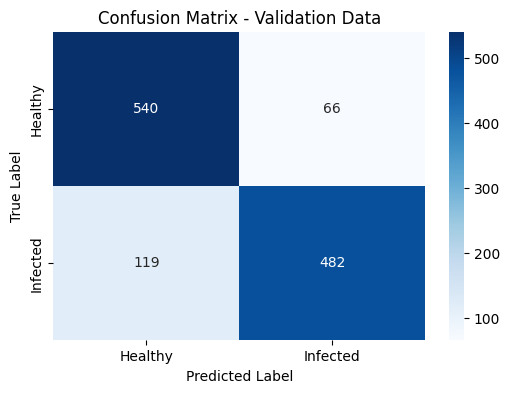

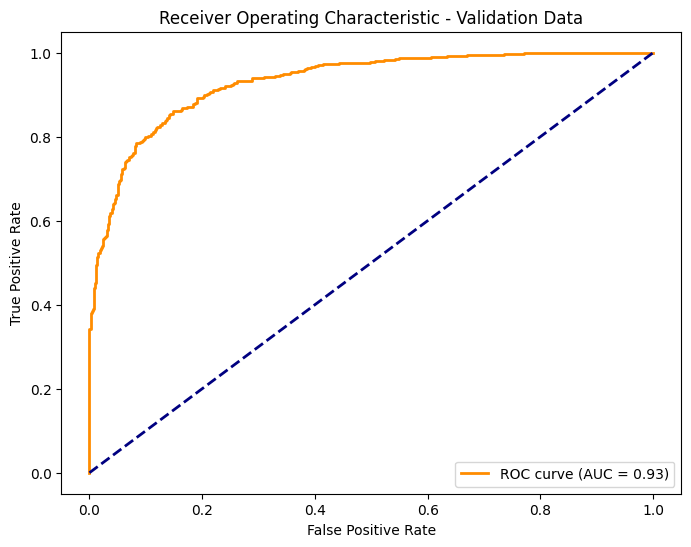


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.64      0.72      0.68       299
    Infected       0.67      0.58      0.62       289

    accuracy                           0.65       588
   macro avg       0.65      0.65      0.65       588
weighted avg       0.65      0.65      0.65       588

Confusion Matrix for Test Data:


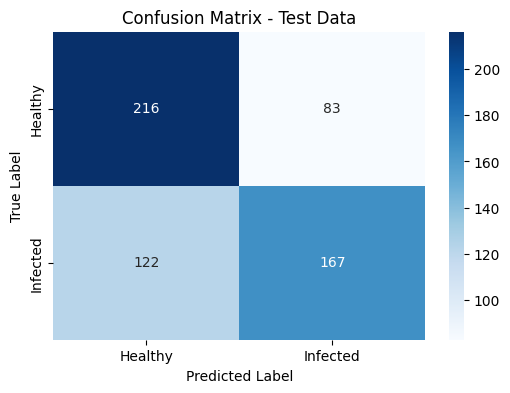

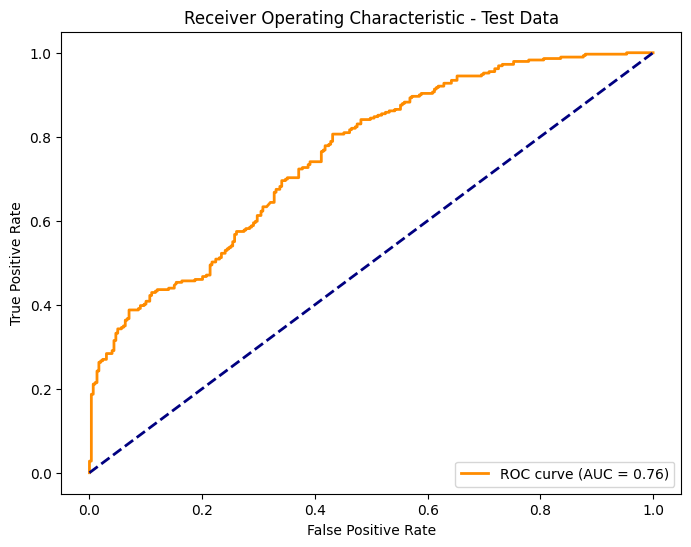

In [1]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract Color Histogram feature and load data
def extract_color_histogram_and_load_data(directory, img_height, img_width, bins=(8, 8, 8)):
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                # Skip non-image files
                continue
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                color_hist = extract_color_histogram(img_array, bins)
                features.append(color_hist)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(features), np.array(labels), class_names

# Feature extraction function: Color Histogram
def extract_color_histogram(image, bins=(8, 8, 8)):
    # Convert the image from RGB to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Compute the color histogram
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_color_histogram_and_load_data(
    train_dir, img_height, img_width, bins=(8, 8, 8))
print(f"Training samples: {X_train.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

print("\nLoading validation data...")
X_val, y_val, _ = extract_color_histogram_and_load_data(
    validation_dir, img_height, img_width, bins=(8, 8, 8))
print(f"Validation samples: {X_val.shape[0]}")

print("\nLoading test data...")
X_test, y_test, _ = extract_color_histogram_and_load_data(
    test_dir, img_height, img_width, bins=(8, 8, 8))
print(f"Test samples: {X_test.shape[0]}")

# Check if data is loaded
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("One of the datasets is empty. Please check the directory paths and image files.")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("\nTraining SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Function to evaluate and plot results
def evaluate_model(model, X, y, class_names, dataset_name='Validation'):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    # Classification report
    print(f'\nClassification Report for {dataset_name} Data:')
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion matrix
    print(f'Confusion Matrix for {dataset_name} Data:')
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve and AUC
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()
    fpr, tpr, _ = roc_curve(y_binarized, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name} Data')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### Color strucutr

Loading training data...
Training samples: 28933
Feature dimension: 8192

Loading validation data...
Validation samples: 1207

Loading test data...
Test samples: 588

Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.83      0.87      0.85       606
    Infected       0.86      0.82      0.84       601

    accuracy                           0.85      1207
   macro avg       0.85      0.85      0.85      1207
weighted avg       0.85      0.85      0.85      1207

Confusion Matrix for Validation Data:


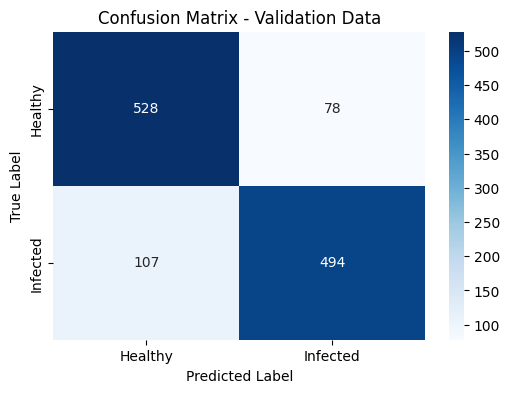

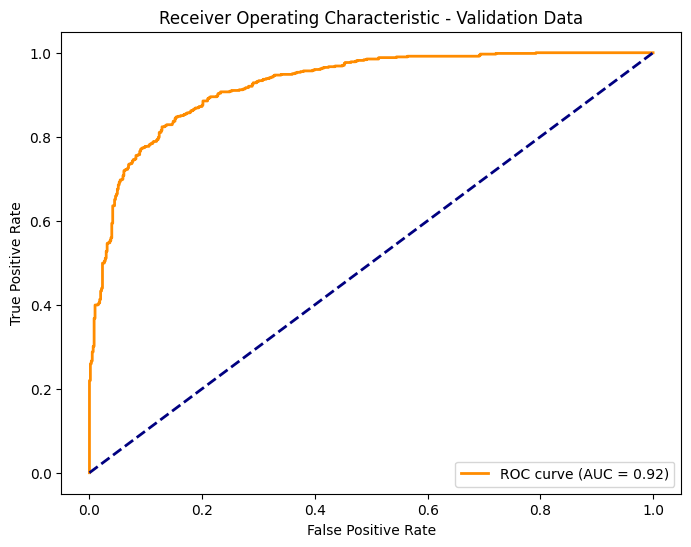


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.67      0.72      0.69       299
    Infected       0.69      0.64      0.66       289

    accuracy                           0.68       588
   macro avg       0.68      0.68      0.68       588
weighted avg       0.68      0.68      0.68       588

Confusion Matrix for Test Data:


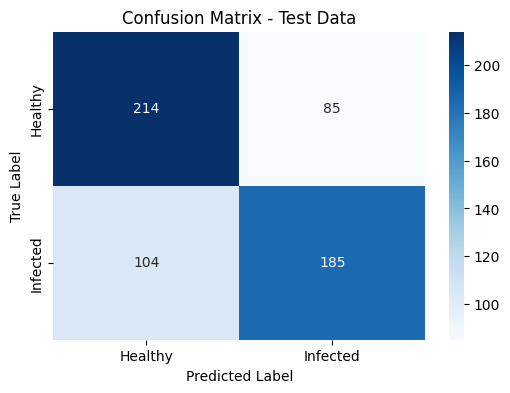

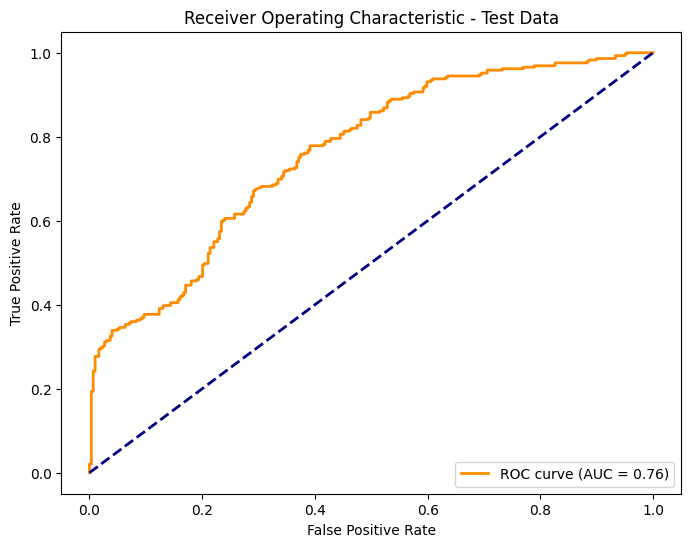

In [ ]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Grid size for Color Structure (e.g., 4x4 grid)
GRID_ROWS = 4
GRID_COLS = 4

# Number of bins per color channel
BINS_PER_CHANNEL = 8

# Function to extract Color Structure feature and load data
def extract_color_structure_and_load_data(directory, img_height, img_width, grid_rows=4, grid_cols=4, bins=(8, 8, 8)):
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            # Skip non-image files
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                color_structure = extract_color_structure(img_array, grid_rows, grid_cols, bins)
                features.append(color_structure)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(features), np.array(labels), class_names

# Feature extraction function: Color Structure
def extract_color_structure(image, grid_rows=4, grid_cols=4, bins=(8, 8, 8)):
    """
    Extracts the Color Structure feature from an image.
    
    Parameters:
    - image: NumPy array of the image in RGB format.
    - grid_rows: Number of rows in the grid.
    - grid_cols: Number of columns in the grid.
    - bins: Number of bins for each color channel.
    
    Returns:
    - feature_vector: 1D NumPy array representing the concatenated histograms.
    """
    # Convert the image from RGB to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Get image dimensions
    height, width, _ = hsv_image.shape
    
    # Compute the size of each grid cell
    cell_height = height // grid_rows
    cell_width = width // grid_cols
    
    feature_vector = []
    
    for row in range(grid_rows):
        for col in range(grid_cols):
            # Define the boundaries of the current grid cell
            y_start = row * cell_height
            y_end = (row + 1) * cell_height if (row + 1) != grid_rows else height
            x_start = col * cell_width
            x_end = (col + 1) * cell_width if (col + 1) != grid_cols else width
            
            # Extract the grid cell
            grid_cell = hsv_image[y_start:y_end, x_start:x_end]
            
            # Compute the color histogram for the grid cell
            hist = cv2.calcHist([grid_cell], [0, 1, 2], None, bins,
                                [0, 180, 0, 256, 0, 256])
            # Normalize the histogram
            hist = cv2.normalize(hist, hist).flatten()
            
            # Append to the feature vector
            feature_vector.extend(hist)
    
    return np.array(feature_vector)

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_color_structure_and_load_data(
    train_dir, img_height, img_width, grid_rows=GRID_ROWS, grid_cols=GRID_COLS, bins=(BINS_PER_CHANNEL, BINS_PER_CHANNEL, BINS_PER_CHANNEL))
print(f"Training samples: {X_train.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

print("\nLoading validation data...")
X_val, y_val, _ = extract_color_structure_and_load_data(
    validation_dir, img_height, img_width, grid_rows=GRID_ROWS, grid_cols=GRID_COLS, bins=(BINS_PER_CHANNEL, BINS_PER_CHANNEL, BINS_PER_CHANNEL))
print(f"Validation samples: {X_val.shape[0]}")

print("\nLoading test data...")
X_test, y_test, _ = extract_color_structure_and_load_data(
    test_dir, img_height, img_width, grid_rows=GRID_ROWS, grid_cols=GRID_COLS, bins=(BINS_PER_CHANNEL, BINS_PER_CHANNEL, BINS_PER_CHANNEL))
print(f"Test samples: {X_test.shape[0]}")

# Check if data is loaded
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("One of the datasets is empty. Please check the directory paths and image files.")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("\nTraining SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Function to evaluate and plot results
def evaluate_model(model, X, y, class_names, dataset_name='Validation'):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    # Classification report
    print(f'\nClassification Report for {dataset_name} Data:')
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion matrix
    print(f'Confusion Matrix for {dataset_name} Data:')
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve and AUC
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()
    fpr, tpr, _ = roc_curve(y_binarized, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name} Data')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### DCT

Loading training data...
Training samples: 28933
Feature dimension: 64

Loading validation data...
Validation samples: 1207

Loading test data...
Test samples: 588

Normalizing features...

Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.70      0.85      0.77       606
    Infected       0.80      0.63      0.71       601

    accuracy                           0.74      1207
   macro avg       0.75      0.74      0.74      1207
weighted avg       0.75      0.74      0.74      1207

Confusion Matrix for Validation Data:


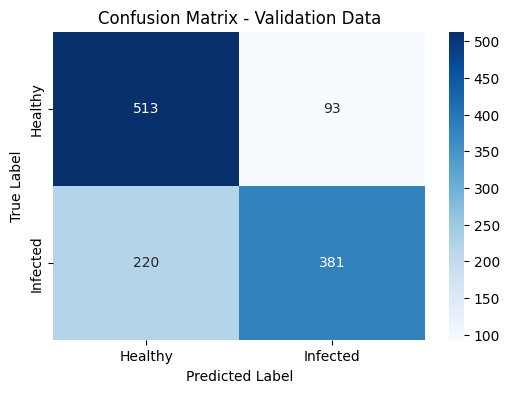

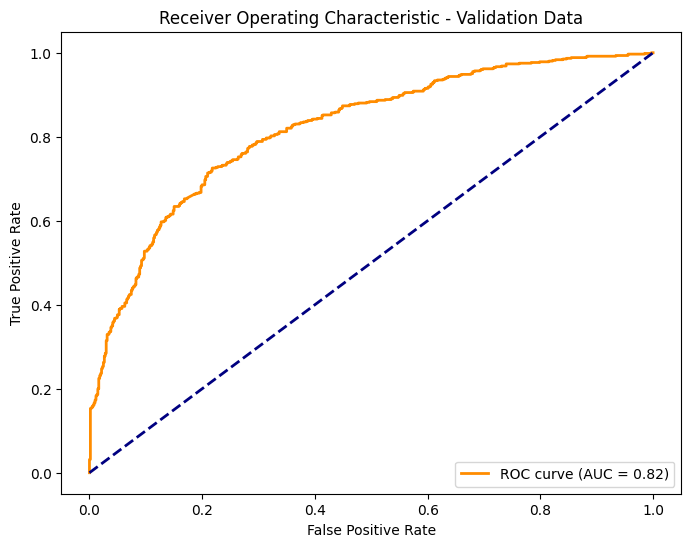


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.68      0.72      0.70       299
    Infected       0.69      0.65      0.67       289

    accuracy                           0.68       588
   macro avg       0.68      0.68      0.68       588
weighted avg       0.68      0.68      0.68       588

Confusion Matrix for Test Data:


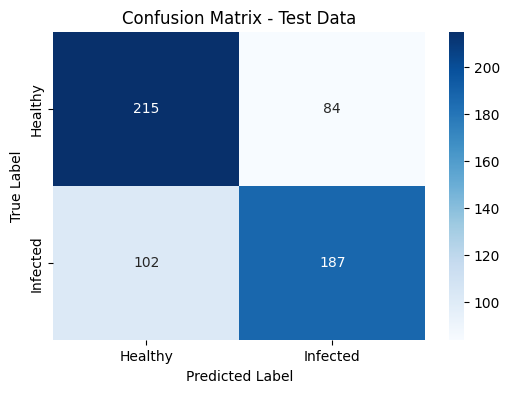

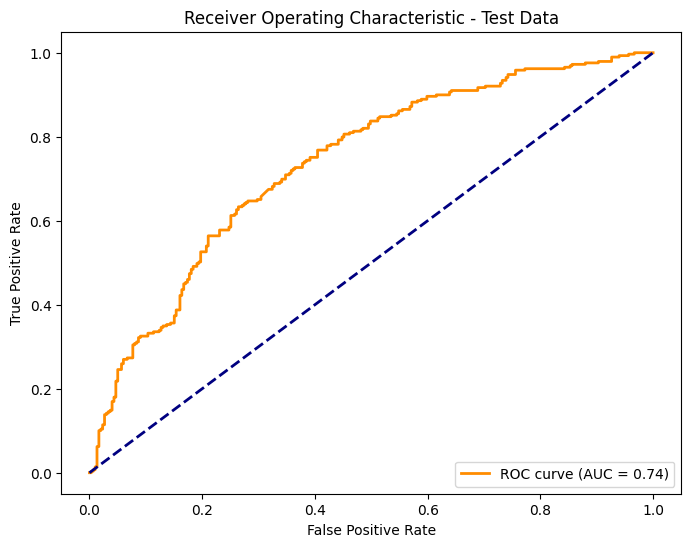

In [4]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract DCT features and load data
def extract_dct_and_load_data(directory, img_height, img_width, dct_size=8):
    """
    Loads images from the specified directory, applies DCT to each image, and extracts DCT features.

    Parameters:
    - directory: Path to the dataset directory.
    - img_height: Desired image height after resizing.
    - img_width: Desired image width after resizing.
    - dct_size: Size of the DCT block (dct_size x dct_size).

    Returns:
    - features: NumPy array of DCT features.
    - labels: NumPy array of corresponding labels.
    - class_names: List of class names.
    """
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            # Skip non-image files
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue
            try:
                # Load image in grayscale
                img = load_img(img_path, color_mode='grayscale', target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("float32")
                # Normalize pixel values to [0,1]
                img_array /= 255.0
                # Apply DCT
                dct_features = extract_dct_features(img_array, dct_size)
                features.append(dct_features)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(features), np.array(labels), class_names

# Feature extraction function: DCT
def extract_dct_features(image, dct_size=8):
    """
    Applies 2D DCT to the image and extracts the top-left dct_size x dct_size coefficients.

    Parameters:
    - image: NumPy array of the grayscale image.
    - dct_size: Number of low-frequency DCT coefficients to retain.

    Returns:
    - dct_features: Flattened DCT feature vector.
    """
    # Apply 2D DCT (type II) using OpenCV
    dct = cv2.dct(image)
    # Extract the top-left dct_size x dct_size coefficients
    dct_low_freq = dct[:dct_size, :dct_size]
    # Flatten to create a feature vector
    dct_features = dct_low_freq.flatten()
    return dct_features

# Function to evaluate and plot results
def evaluate_model(model, X, y, class_names, dataset_name='Validation'):
    """
    Evaluates the trained model on the given dataset and plots evaluation metrics.

    Parameters:
    - model: Trained classification model.
    - X: Feature matrix.
    - y: True labels.
    - class_names: List of class names.
    - dataset_name: Name of the dataset (e.g., 'Validation', 'Test').
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # Probability estimates for the positive class
    
    # Classification report
    print(f'\nClassification Report for {dataset_name} Data:')
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion matrix
    print(f'Confusion Matrix for {dataset_name} Data:')
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve and AUC
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()
    fpr, tpr, _ = roc_curve(y_binarized, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name} Data')
    plt.legend(loc="lower right")
    plt.show()

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_dct_and_load_data(
    train_dir, img_height, img_width, dct_size=8)
print(f"Training samples: {X_train.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

print("\nLoading validation data...")
X_val, y_val, _ = extract_dct_and_load_data(
    validation_dir, img_height, img_width, dct_size=8)
print(f"Validation samples: {X_val.shape[0]}")

print("\nLoading test data...")
X_test, y_test, _ = extract_dct_and_load_data(
    test_dir, img_height, img_width, dct_size=8)
print(f"Test samples: {X_test.shape[0]}")

# Check if data is loaded
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("One of the datasets is empty. Please check the directory paths and image files.")

# Normalize features
print("\nNormalizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("\nTraining SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### Regional shape

Loading training data...
Training samples: 28933
Feature dimension: 7

Loading validation data...
Validation samples: 1207

Loading test data...
Test samples: 588

Normalizing features...

Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.59      0.58      0.58       606
    Infected       0.58      0.59      0.59       601

    accuracy                           0.58      1207
   macro avg       0.58      0.58      0.58      1207
weighted avg       0.58      0.58      0.58      1207

Confusion Matrix for Validation Data:


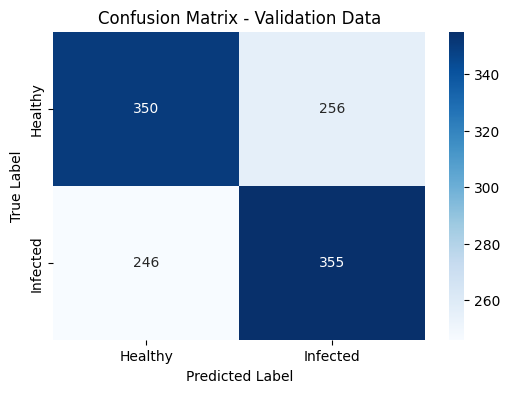

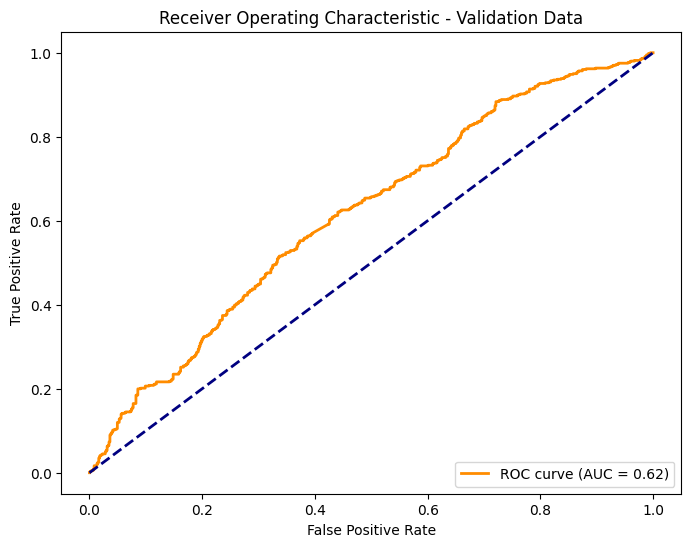


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.54      0.39      0.45       299
    Infected       0.51      0.65      0.57       289

    accuracy                           0.52       588
   macro avg       0.52      0.52      0.51       588
weighted avg       0.52      0.52      0.51       588

Confusion Matrix for Test Data:


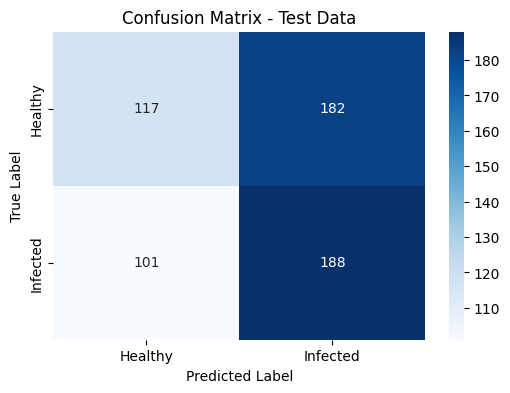

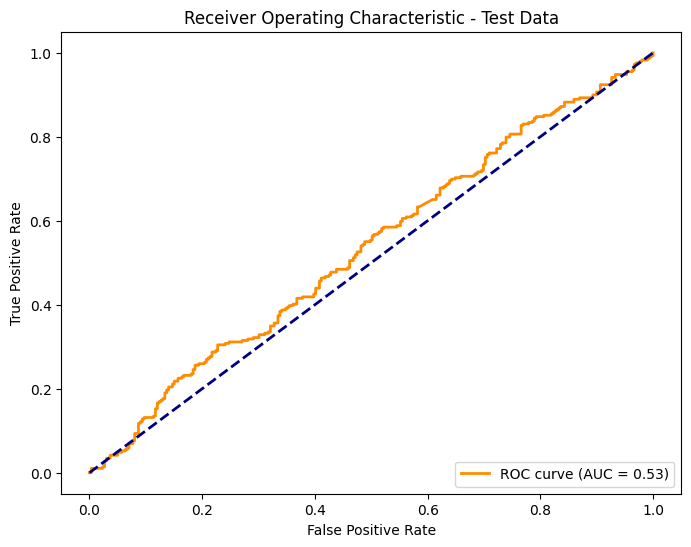

In [5]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract Shape Features and load data
def extract_shape_features_and_load_data(directory, img_height, img_width):
    """
    Loads images from the specified directory, segments the leaf, and extracts shape features.
    
    Parameters:
    - directory: Path to the dataset directory.
    - img_height: Desired image height after resizing.
    - img_width: Desired image width after resizing.
    
    Returns:
    - features: NumPy array of shape features.
    - labels: NumPy array of corresponding labels.
    - class_names: List of class names.
    """
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            # Skip non-image files
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue
            try:
                # Load image in grayscale
                img = load_img(img_path, color_mode='grayscale', target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8").reshape(img_height, img_width)
                
                # Segment the leaf using thresholding
                _, thresh = cv2.threshold(img_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                
                # Optional: Apply morphological operations to remove noise
                kernel = np.ones((3,3), np.uint8)
                thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
                thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
                
                # Find contours
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                if len(contours) == 0:
                    print(f"No contours found in image {img_path}. Skipping...")
                    continue
                
                # Assume the largest contour corresponds to the leaf
                largest_contour = max(contours, key=cv2.contourArea)
                
                # Compute Hu Moments
                hu_moments = cv2.HuMoments(cv2.moments(largest_contour)).flatten()
                
                # Log transform Hu Moments to bring them to a comparable scale
                hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
                
                features.append(hu_moments)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    
    return np.array(features), np.array(labels), class_names

# Function to evaluate and plot results
def evaluate_model(model, X, y, class_names, dataset_name='Validation'):
    """
    Evaluates the trained model on the given dataset and plots evaluation metrics.
    
    Parameters:
    - model: Trained classification model.
    - X: Feature matrix.
    - y: True labels.
    - class_names: List of class names.
    - dataset_name: Name of the dataset (e.g., 'Validation', 'Test').
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # Probability estimates for the positive class
    
    # Classification report
    print(f'\nClassification Report for {dataset_name} Data:')
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion matrix
    print(f'Confusion Matrix for {dataset_name} Data:')
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve and AUC
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()
    fpr, tpr, _ = roc_curve(y_binarized, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name} Data')
    plt.legend(loc="lower right")
    plt.show()

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_shape_features_and_load_data(
    train_dir, img_height, img_width)
print(f"Training samples: {X_train.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

print("\nLoading validation data...")
X_val, y_val, _ = extract_shape_features_and_load_data(
    validation_dir, img_height, img_width)
print(f"Validation samples: {X_val.shape[0]}")

print("\nLoading test data...")
X_test, y_test, _ = extract_shape_features_and_load_data(
    test_dir, img_height, img_width)
print(f"Test samples: {X_test.shape[0]}")

# Check if data is loaded
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("One of the datasets is empty. Please check the directory paths and image files.")

# Normalize features
print("\nNormalizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("\nTraining SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### Contour shape

Loading training data...
Training samples: 28933
Feature dimension: 10

Loading validation data...
Validation samples: 1207

Loading test data...
Test samples: 588

Normalizing features...

Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.61      0.54      0.57       606
    Infected       0.58      0.65      0.61       601

    accuracy                           0.59      1207
   macro avg       0.59      0.59      0.59      1207
weighted avg       0.59      0.59      0.59      1207

Confusion Matrix for Validation Data:


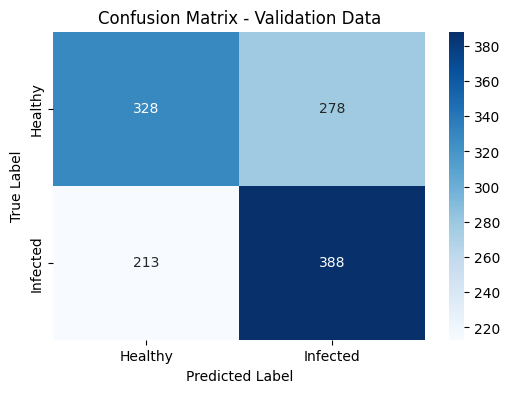

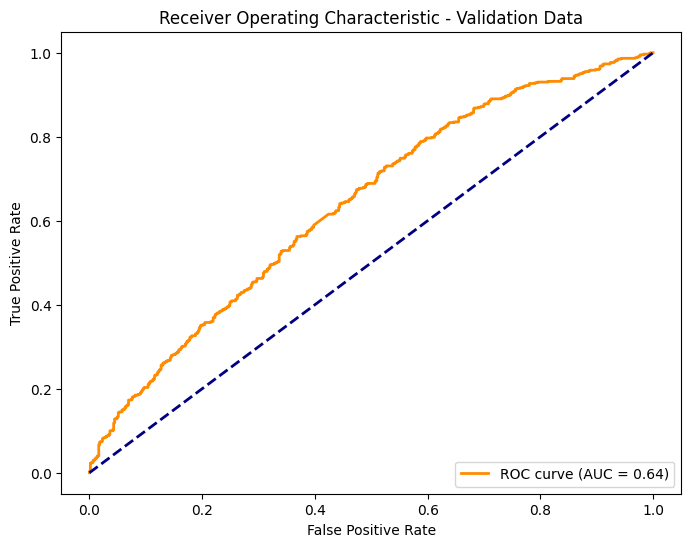

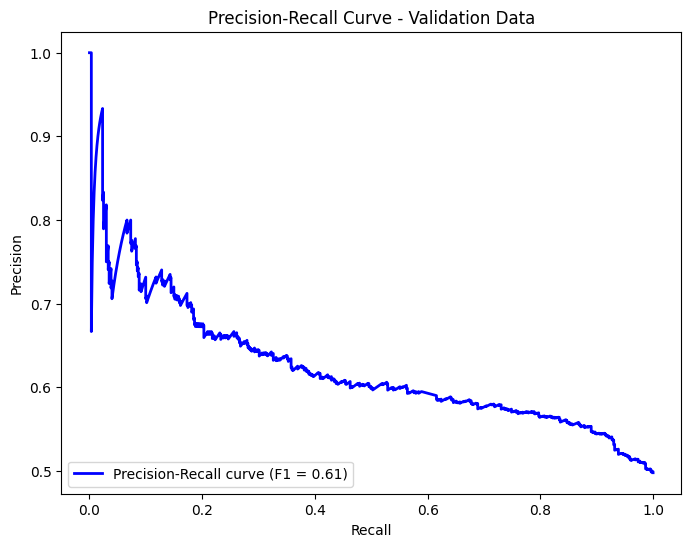


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.54      0.42      0.48       299
    Infected       0.51      0.63      0.57       289

    accuracy                           0.53       588
   macro avg       0.53      0.53      0.52       588
weighted avg       0.53      0.53      0.52       588

Confusion Matrix for Test Data:


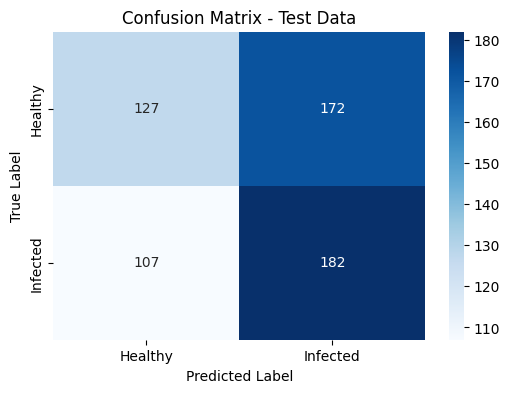

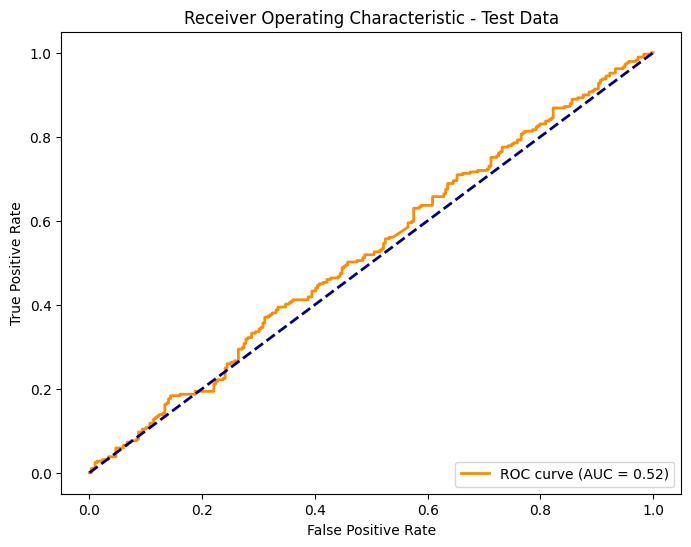

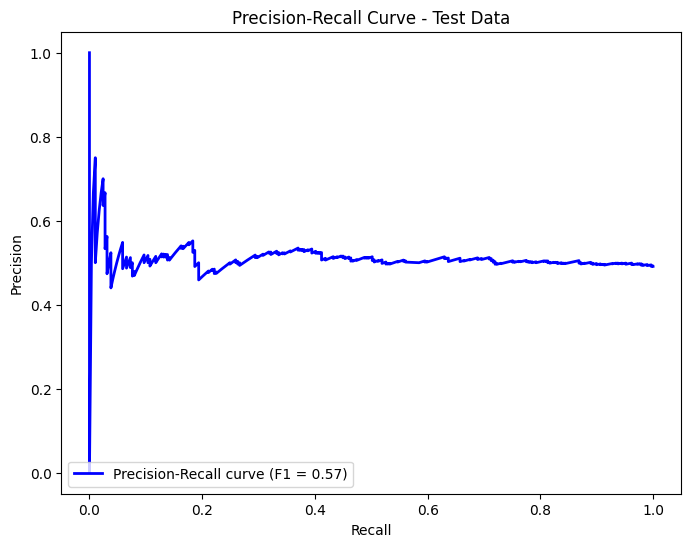

In [7]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_fscore_support
)
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract Contour Shape Features and load data
def extract_contour_shape_features_and_load_data(directory, img_height, img_width):
    """
    Loads images from the specified directory, segments the leaf, and extracts contour-based shape features.
    
    Parameters:
    - directory: Path to the dataset directory.
    - img_height: Desired image height after resizing.
    - img_width: Desired image width after resizing.
    
    Returns:
    - features: NumPy array of contour shape features.
    - labels: NumPy array of corresponding labels.
    - class_names: List of class names.
    """
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            # Skip non-image files
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue
            try:
                # Load image in grayscale
                img = load_img(img_path, color_mode='grayscale', target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8").reshape(img_height, img_width)
                
                # Segment the leaf using thresholding
                _, thresh = cv2.threshold(img_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                
                # Apply morphological operations to remove noise and fill gaps
                kernel = np.ones((3,3), np.uint8)
                thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
                thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
                
                # Find contours
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                if len(contours) == 0:
                    print(f"No contours found in image {img_path}. Skipping...")
                    continue
                
                # Assume the largest contour corresponds to the leaf
                largest_contour = max(contours, key=cv2.contourArea)
                
                # Compute contour-based shape features
                shape_features = compute_contour_features(largest_contour, img_array)
                
                features.append(shape_features)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    
    return np.array(features), np.array(labels), class_names

# Function to compute contour-based shape features
def compute_contour_features(contour, image):
    """
    Computes various contour-based shape features from the largest contour.
    
    Parameters:
    - contour: Contour of the leaf.
    - image: Grayscale image array.
    
    Returns:
    - features: List of computed shape features.
    """
    # Area
    area = cv2.contourArea(contour)
    
    # Perimeter
    perimeter = cv2.arcLength(contour, True)
    
    # Bounding Rectangle
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h != 0 else 0
    
    # Extent
    rect_area = w * h
    extent = float(area) / rect_area if rect_area != 0 else 0
    
    # Convex Hull and Solidity
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area != 0 else 0
    
    # Equivalent Diameter
    equi_diameter = np.sqrt(4 * area / np.pi) if area != 0 else 0
    
    # Orientation and Moments
    moments = cv2.moments(contour)
    if moments['mu02'] != 0:
        orientation = 0.5 * np.arctan2(2 * moments['mu11'], moments['mu20'] - moments['mu02'])
    else:
        orientation = 0
    
    # Fit Ellipse and Major/Minor Axis Lengths
    if len(contour) >= 5:
        ellipse = cv2.fitEllipse(contour)
        (center, axes, angle) = ellipse
        major_axis_length = max(axes)
        minor_axis_length = min(axes)
    else:
        major_axis_length = 0
        minor_axis_length = 0
    
    # Circularity
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0
    
    # Haralick Texture Features (optional, requires additional library)
    # Here, we stick to purely contour-based features
    
    # Compile all features into a list
    features = [
        area,
        perimeter,
        aspect_ratio,
        extent,
        solidity,
        equi_diameter,
        orientation,
        major_axis_length,
        minor_axis_length,
        circularity
    ]
    
    return features

# Import the missing functions
from sklearn.metrics import precision_recall_curve, f1_score

# Function to evaluate and plot results
def evaluate_model(model, X, y, class_names, dataset_name='Validation'):
    """
    Evaluates the trained model on the given dataset and plots evaluation metrics.
    
    Parameters:
    - model: Trained classification model.
    - X: Feature matrix.
    - y: True labels.
    - class_names: List of class names.
    - dataset_name: Name of the dataset (e.g., 'Validation', 'Test').
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # Probability estimates for the positive class
    
    # Classification report
    print(f'\nClassification Report for {dataset_name} Data:')
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion matrix
    print(f'Confusion Matrix for {dataset_name} Data:')
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve and AUC
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()
    fpr, tpr, _ = roc_curve(y_binarized, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name} Data')
    plt.legend(loc="lower right")
    plt.show()
    
    # Precision-Recall Curve and F1-Score
    precision, recall, _ = precision_recall_curve(y_binarized, y_prob)
    f1 = f1_score(y, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (F1 = {f1:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {dataset_name} Data')
    plt.legend(loc="lower left")
    plt.show()

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_contour_shape_features_and_load_data(
    train_dir, img_height, img_width)
print(f"Training samples: {X_train.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

print("\nLoading validation data...")
X_val, y_val, _ = extract_contour_shape_features_and_load_data(
    validation_dir, img_height, img_width)
print(f"Validation samples: {X_val.shape[0]}")

print("\nLoading test data...")
X_test, y_test, _ = extract_contour_shape_features_and_load_data(
    test_dir, img_height, img_width)
print(f"Test samples: {X_test.shape[0]}")

# Check if data is loaded
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("One of the datasets is empty. Please check the directory paths and image files.")

# Normalize features
print("\nNormalizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("\nTraining SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### Humoments with shape features

Loading training data...
Training samples: 28933
Loading validation data...
Validation samples: 1207
Loading test data...
Test samples: 588
Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.61      0.58      0.59       606
    Infected       0.59      0.62      0.61       601

    accuracy                           0.60      1207
   macro avg       0.60      0.60      0.60      1207
weighted avg       0.60      0.60      0.60      1207

Confusion Matrix for Validation Data:


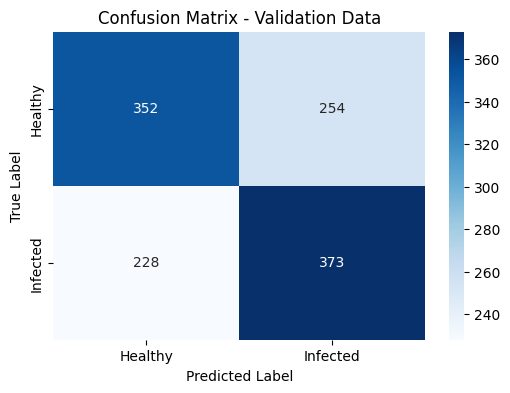

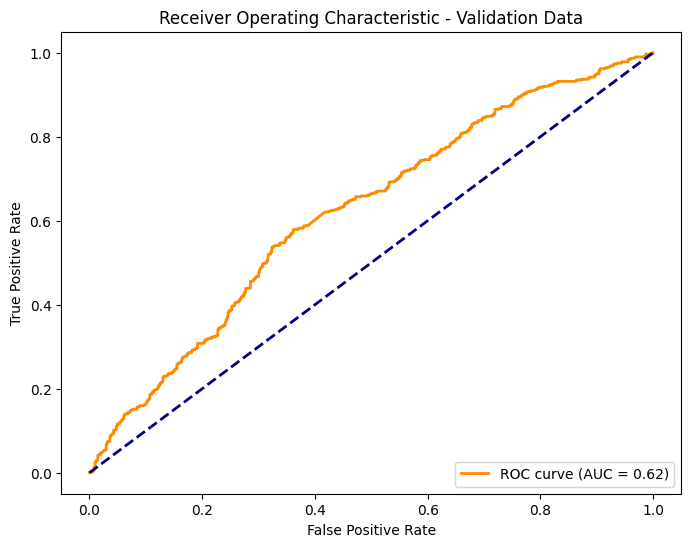


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.51      0.38      0.44       299
    Infected       0.49      0.62      0.55       289

    accuracy                           0.50       588
   macro avg       0.50      0.50      0.49       588
weighted avg       0.50      0.50      0.49       588

Confusion Matrix for Test Data:


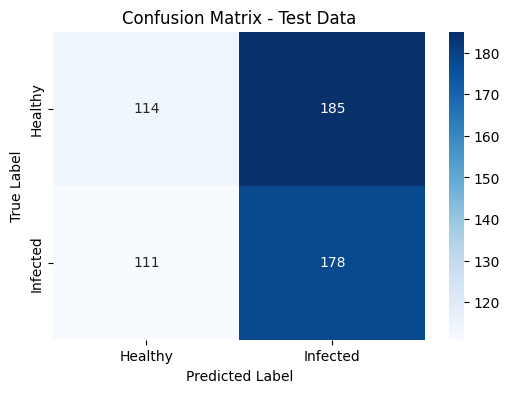

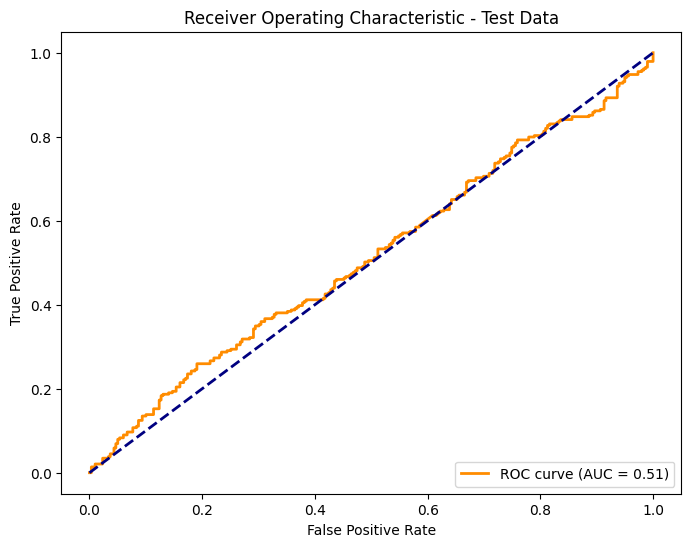

In [4]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract shape features and load data
def extract_shape_features_and_load_data(directory, img_height, img_width):
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                shape_features = extract_shape_features(img_array)
                features.append(shape_features)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(features), np.array(labels), class_names

# Feature extraction function: Shape Features using Hu Moments
def extract_shape_features(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply thresholding to get binary image
    _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Compute Hu Moments
    if len(contours) > 0:
        # Assuming the largest contour is the object of interest
        cnt = max(contours, key=cv2.contourArea)
        hu_moments = cv2.HuMoments(cv2.moments(cnt)).flatten()
        # Log transform to make values more manageable
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    else:
        # If no contours found, use zeros
        hu_moments = np.zeros(7)
    return hu_moments

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_shape_features_and_load_data(train_dir, img_height, img_width)
print(f"Training samples: {X_train.shape[0]}")

print("Loading validation data...")
X_val, y_val, _ = extract_shape_features_and_load_data(validation_dir, img_height, img_width)
print(f"Validation samples: {X_val.shape[0]}")

print("Loading test data...")
X_test, y_test, _ = extract_shape_features_and_load_data(test_dir, img_height, img_width)
print(f"Test samples: {X_test.shape[0]}")

# Check if data is loaded
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("One of the datasets is empty. Please check the directory paths and image files.")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Function to evaluate and plot results
def evaluate_model(model, X, y, class_names, dataset_name='Validation'):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    # Classification report
    print(f'\nClassification Report for {dataset_name} Data:')
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Confusion matrix
    print(f'Confusion Matrix for {dataset_name} Data:')
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve and AUC
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()
    fpr, tpr, _ = roc_curve(y_binarized, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name} Data')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### Color Histograms in HSV Color Space

Loading training data...
Training samples: 28933
Feature dimension: 512
Loading validation data...
Validation samples: 1207
Loading test data...
Test samples: 588
Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.82      0.89      0.85       606
    Infected       0.88      0.80      0.84       601

    accuracy                           0.85      1207
   macro avg       0.85      0.85      0.85      1207
weighted avg       0.85      0.85      0.85      1207

Confusion Matrix for Validation Data:


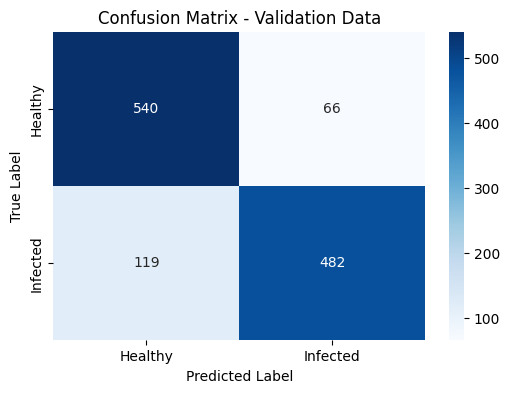

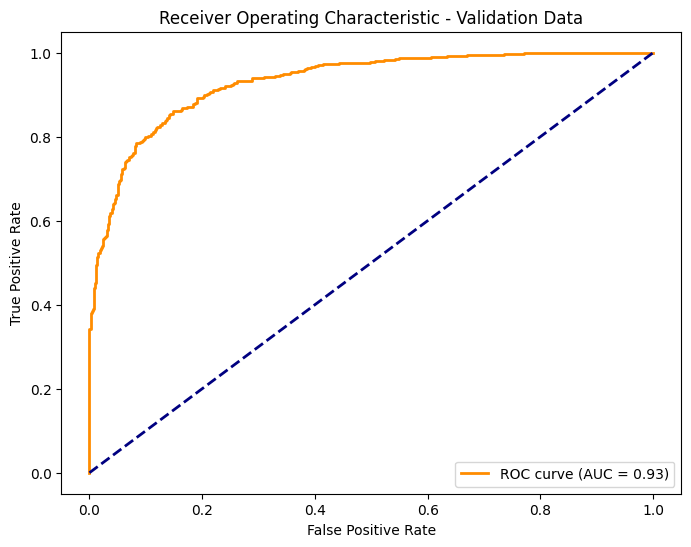


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.64      0.72      0.68       299
    Infected       0.67      0.58      0.62       289

    accuracy                           0.65       588
   macro avg       0.65      0.65      0.65       588
weighted avg       0.65      0.65      0.65       588

Confusion Matrix for Test Data:


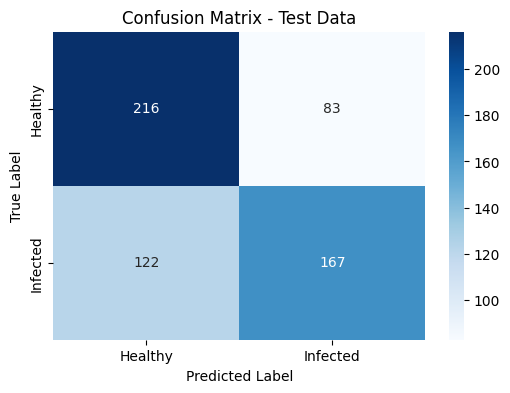

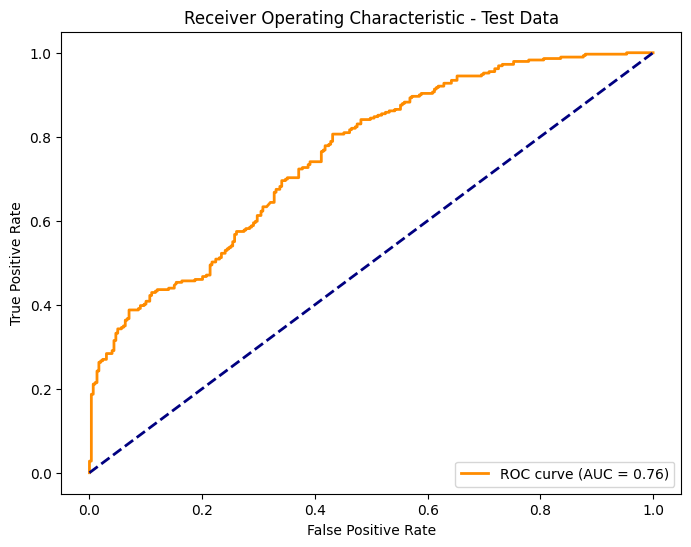

In [1]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract Color Histogram feature and load data
def extract_color_histogram_and_load_data(directory, img_height, img_width, bins=(8, 8, 8)):
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            # Skip non-image files
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img)
                color_hist = extract_color_histogram(img_array, bins)
                features.append(color_hist)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(features), np.array(labels), class_names

# Feature extraction function: Color Histogram in HSV color space
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv_image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_color_histogram_and_load_data(train_dir, img_height, img_width)
print(f"Training samples: {X_train.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

print("Loading validation data...")
X_val, y_val, _ = extract_color_histogram_and_load_data(validation_dir, img_height, img_width)
print(f"Validation samples: {X_val.shape[0]}")

print("Loading test data...")
X_test, y_test, _ = extract_color_histogram_and_load_data(test_dir, img_height, img_width)
print(f"Test samples: {X_test.shape[0]}")

# Check if data is loaded
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("One of the datasets is empty. Please check the directory paths and image files.")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Function to evaluate and plot results
def evaluate_model(model, X, y, class_names, dataset_name='Validation'):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    # Classification report
    print(f'\nClassification Report for {dataset_name} Data:')
    print(classification_report(y, y_pred, target_names=class_names))

    # Confusion matrix
    print(f'Confusion Matrix for {dataset_name} Data:')
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve and AUC
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()
    fpr, tpr, _ = roc_curve(y_binarized, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name} Data')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### Color Moments

Loading training data...
Training samples: 28933
Feature dimension: 9
Loading validation data...
Validation samples: 1207
Loading test data...
Test samples: 588
Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.81      0.88      0.84       606
    Infected       0.87      0.79      0.83       601

    accuracy                           0.83      1207
   macro avg       0.84      0.83      0.83      1207
weighted avg       0.84      0.83      0.83      1207

Confusion Matrix for Validation Data:


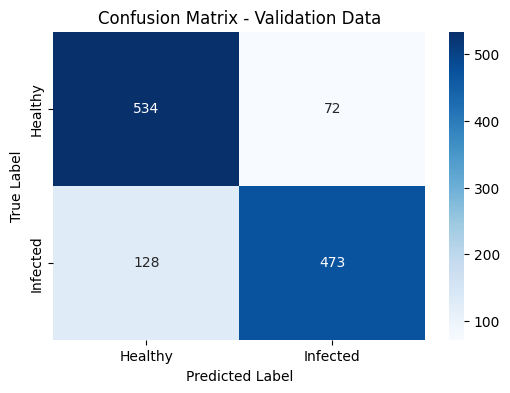

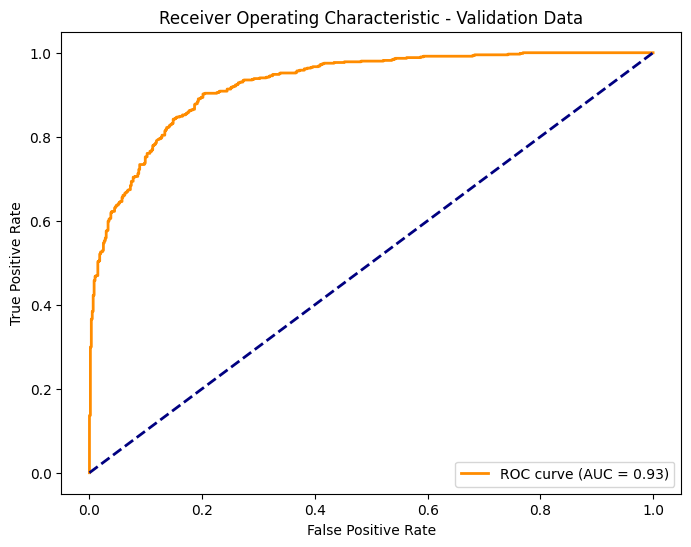


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.70      0.96      0.81       299
    Infected       0.93      0.57      0.71       289

    accuracy                           0.77       588
   macro avg       0.82      0.77      0.76       588
weighted avg       0.81      0.77      0.76       588

Confusion Matrix for Test Data:


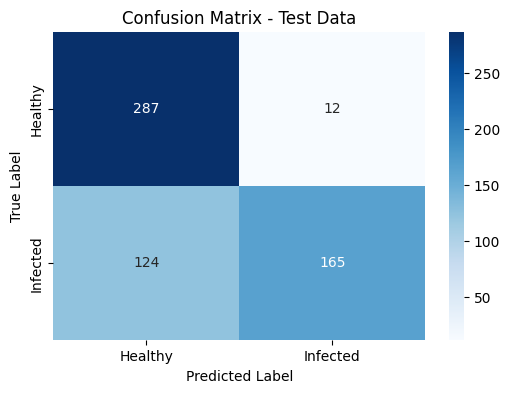

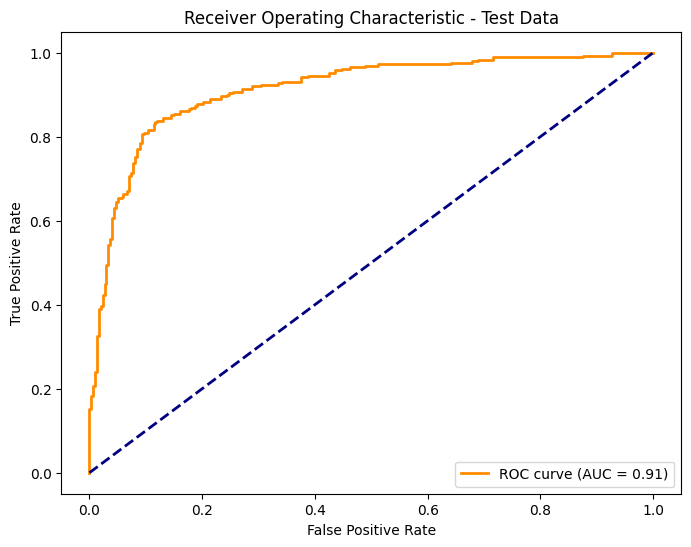

In [2]:
import os
import numpy as np
import cv2
from scipy.stats import skew
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract Color Moments feature and load data
def extract_color_moments_and_load_data(directory, img_height, img_width):
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            # Skip non-image files
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img)
                color_moments = extract_color_moments(img_array)
                features.append(color_moments)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(features), np.array(labels), class_names

# Feature extraction function: Color Moments
def extract_color_moments(image):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV)
    # Split channels
    channels = cv2.split(hsv_image)
    moments = []
    for channel in channels:
        # Flatten the channel
        channel = channel.flatten()
        # Calculate moments
        mean = np.mean(channel)
        std = np.std(channel)
        sk = skew(channel)
        moments.extend([mean, std, sk])
    return np.array(moments)

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_color_moments_and_load_data(train_dir, img_height, img_width)
print(f"Training samples: {X_train.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

print("Loading validation data...")
X_val, y_val, _ = extract_color_moments_and_load_data(validation_dir, img_height, img_width)
print(f"Validation samples: {X_val.shape[0]}")

print("Loading test data...")
X_test, y_test, _ = extract_color_moments_and_load_data(test_dir, img_height, img_width)
print(f"Test samples: {X_test.shape[0]}")

# Check if data is loaded
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    raise ValueError("One of the datasets is empty. Please check the directory paths and image files.")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### Dominant color descriptor

Loading training data...
Training samples: 28933
Feature dimension: 9
Loading validation data...
Validation samples: 1207
Loading test data...
Test samples: 588
Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.74      0.88      0.80       606
    Infected       0.85      0.69      0.76       601

    accuracy                           0.78      1207
   macro avg       0.79      0.78      0.78      1207
weighted avg       0.79      0.78      0.78      1207

Confusion Matrix for Validation Data:


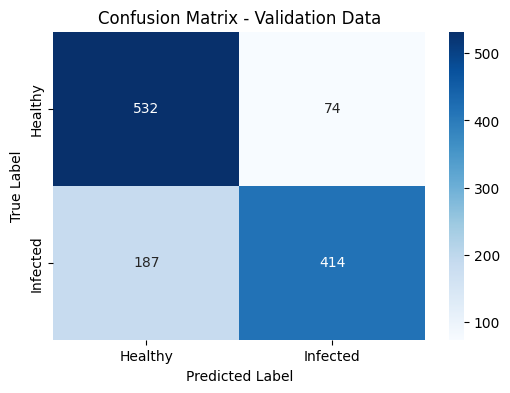

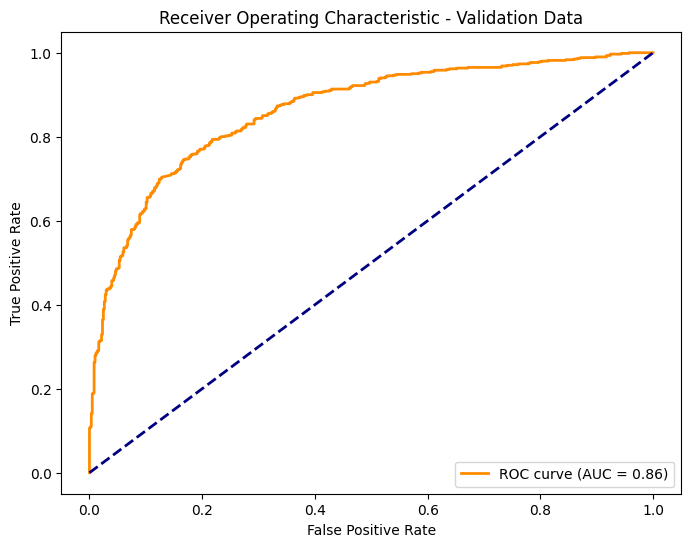


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.65      0.94      0.77       299
    Infected       0.88      0.49      0.63       289

    accuracy                           0.72       588
   macro avg       0.77      0.71      0.70       588
weighted avg       0.77      0.72      0.70       588

Confusion Matrix for Test Data:


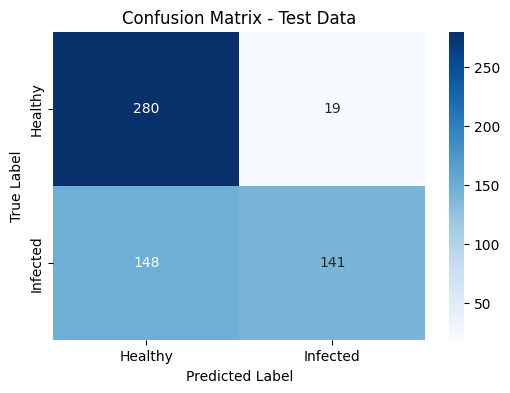

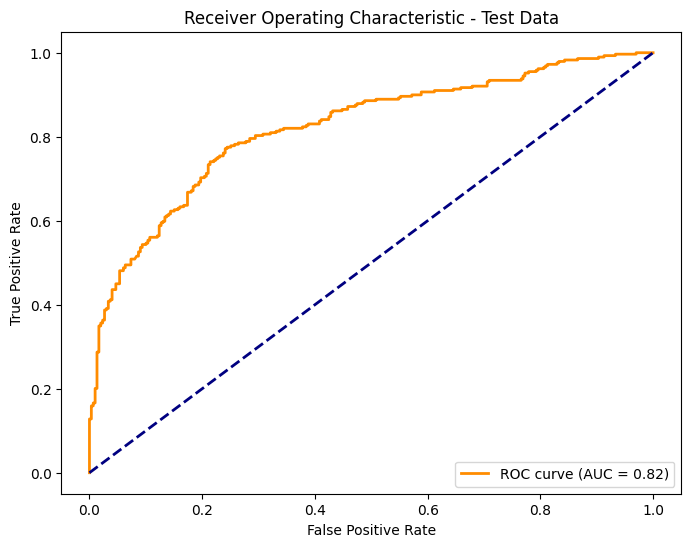

In [6]:
import os
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract Dominant Color feature and load data
def extract_dominant_color_and_load_data(directory, img_height, img_width, num_colors=3):
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                dominant_colors = extract_dominant_color(img_array, num_colors)
                features.append(dominant_colors)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(features), np.array(labels), class_names

# Feature extraction function: Dominant Color
def extract_dominant_color(image, num_colors=3):
    # Reshape image to a list of pixels
    pixels = image.reshape(-1, 3)
    # Apply KMeans to find dominant colors
    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    kmeans.fit(pixels)
    # Get cluster centers (dominant colors)
    dominant_colors = kmeans.cluster_centers_.flatten()
    return dominant_colors

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_dominant_color_and_load_data(train_dir, img_height, img_width)
print(f"Training samples: {X_train.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

print("Loading validation data...")
X_val, y_val, _ = extract_dominant_color_and_load_data(validation_dir, img_height, img_width)
print(f"Validation samples: {X_val.shape[0]}")

print("Loading test data...")
X_test, y_test, _ = extract_dominant_color_and_load_data(test_dir, img_height, img_width)
print(f"Test samples: {X_test.shape[0]}")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Function to evaluate and plot results (same as before)
def evaluate_model(model, X, y, class_names, dataset_name='Validation'):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    # Classification report
    print(f'\nClassification Report for {dataset_name} Data:')
    print(classification_report(y, y_pred, target_names=class_names))
    # Confusion matrix
    print(f'Confusion Matrix for {dataset_name} Data:')
    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    # ROC Curve and AUC
    lb = LabelBinarizer()
    y_binarized = lb.fit_transform(y).ravel()
    fpr, tpr, _ = roc_curve(y_binarized, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {dataset_name} Data')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### Color Layout Descriptor

Loading training data...
Training samples: 28933
Feature dimension: 192
Loading validation data...
Validation samples: 1207
Loading test data...
Test samples: 588
Training SVM classifier...
Training completed.

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.76      0.88      0.82       606
    Infected       0.86      0.72      0.78       601

    accuracy                           0.80      1207
   macro avg       0.81      0.80      0.80      1207
weighted avg       0.81      0.80      0.80      1207

Confusion Matrix for Validation Data:


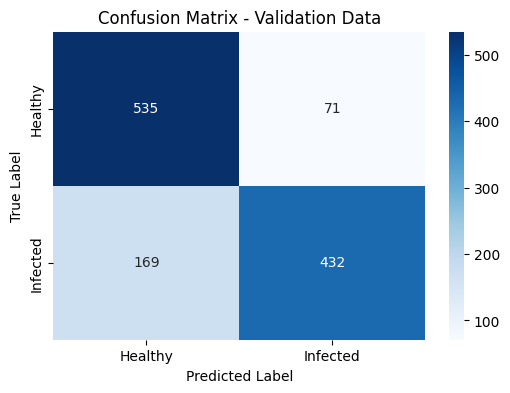

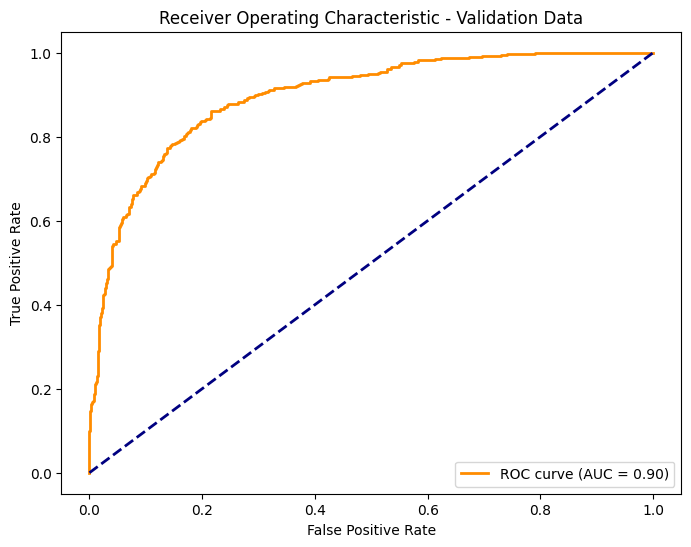


Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.71      0.88      0.79       299
    Infected       0.83      0.63      0.72       289

    accuracy                           0.76       588
   macro avg       0.77      0.75      0.75       588
weighted avg       0.77      0.76      0.75       588

Confusion Matrix for Test Data:


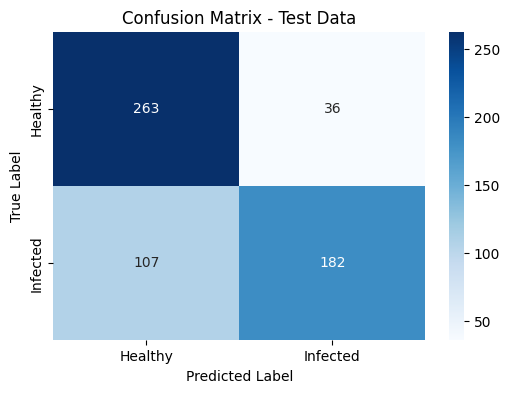

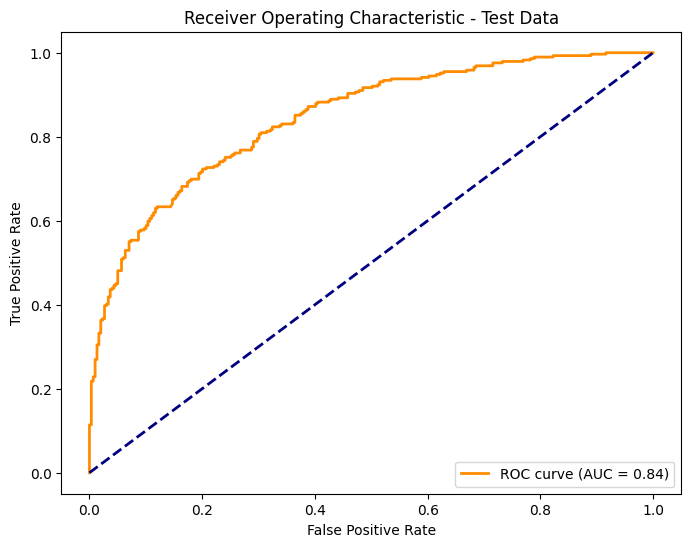

In [8]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Dataset directories (same as before)

# Image size
img_height, img_width = 256, 256

# Function to extract Color Layout feature and load data
def extract_color_layout_and_load_data(directory, img_height, img_width, grid_size=(8, 8)):
    features = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                cld = extract_color_layout(img_array, grid_size)
                features.append(cld)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(features), np.array(labels), class_names

# Feature extraction function: Color Layout Descriptor
def extract_color_layout(image, grid_size=(8, 8)):
    h, w, _ = image.shape
    grid_h, grid_w = grid_size
    features = []
    # Resize image to match grid size
    resized = cv2.resize(image, (grid_w, grid_h))
    # Convert to YCbCr color space
    ycbcr_image = cv2.cvtColor(resized, cv2.COLOR_RGB2YCrCb)
    # Flatten channels
    for i in range(3):  # Y, Cr, Cb
        channel = ycbcr_image[:, :, i]
        features.extend(channel.flatten())
    return np.array(features)

# Load and process data
print("Loading training data...")
X_train, y_train, class_names = extract_color_layout_and_load_data(train_dir, img_height, img_width)
print(f"Training samples: {X_train.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

print("Loading validation data...")
X_val, y_val, _ = extract_color_layout_and_load_data(validation_dir, img_height, img_width)
print(f"Validation samples: {X_val.shape[0]}")

print("Loading test data...")
X_test, y_test, _ = extract_color_layout_and_load_data(test_dir, img_height, img_width)
print(f"Test samples: {X_test.shape[0]}")

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
print("Training SVM classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("Training completed.")

# Evaluate on Validation Data
evaluate_model(svm, X_val, y_val, class_names, dataset_name='Validation')

# Evaluate on Test Data
evaluate_model(svm, X_test, y_test, class_names, dataset_name='Test')


### Final

In [7]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import time

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract features and load data
def extract_features_and_load_data(directory, img_height, img_width):
    images = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                features = extract_combined_features(img_array)
                images.append(features)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

# Feature extraction functions

# Feature extraction function: Color Structure
def extract_color_structure(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Feature extraction function: Edge Histogram
def extract_edge_histogram(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    hist = cv2.calcHist([edges], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Feature extraction function: Color Layout Descriptor
def extract_color_layout(image, grid_size=(8, 8)):
    h, w, _ = image.shape
    grid_h, grid_w = grid_size
    features = []
    # Resize image to match grid size
    resized = cv2.resize(image, (grid_w, grid_h))
    # Convert to YCbCr color space
    ycbcr_image = cv2.cvtColor(resized, cv2.COLOR_RGB2YCrCb)
    # Flatten channels
    for i in range(3):  # Y, Cr, Cb
        channel = ycbcr_image[:, :, i]
        features.extend(channel.flatten())
    return np.array(features)

# Feature extraction function: Color Moments
def extract_color_moments(image):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV)
    # Split channels
    channels = cv2.split(hsv_image)
    moments = []
    for channel in channels:
        # Flatten the channel
        channel = channel.flatten()
        # Calculate moments
        mean = np.mean(channel)
        std = np.std(channel)
        sk = skew(channel)
        moments.extend([mean, std, sk])
    return np.array(moments)

# Combined feature extraction function using the new descriptors
def extract_combined_features(image):
    color_structure = extract_color_structure(image)
    edge_histogram = extract_edge_histogram(image)
    color_layout = extract_color_layout(image)
    color_moments = extract_color_moments(image)
    combined_features = np.hstack([color_structure, edge_histogram, color_layout, color_moments])
    return combined_features

# Load and process data
print("Extracting features from training data...")
X_train, y_train, class_names = extract_features_and_load_data(train_dir, img_height, img_width)
print(f"Training data: {X_train.shape}, Labels: {y_train.shape}")

print("Extracting features from validation data...")
X_val, y_val, _ = extract_features_and_load_data(validation_dir, img_height, img_width)
print(f"Validation data: {X_val.shape}, Labels: {y_val.shape}")

print("Extracting features from test data...")
X_test, y_test, _ = extract_features_and_load_data(test_dir, img_height, img_width)
print(f"Test data: {X_test.shape}, Labels: {y_test.shape}")

# Normalize features
print("Normalizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


Extracting features from training data...
Training data: (28933, 969), Labels: (28933,)
Extracting features from validation data...
Validation data: (1207, 969), Labels: (1207,)
Extracting features from test data...
Test data: (588, 969), Labels: (588,)
Normalizing features...


In [ ]:
# Train SVM
print("Training Support Vector Machine (SVM) classifier...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("SVM training completed.")

SVM model saved as 'svm_model.joblib'.
Predicting on validation data...
Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.86      0.94      0.89       606
    Infected       0.93      0.84      0.88       601

    accuracy                           0.89      1207
   macro avg       0.89      0.89      0.89      1207
weighted avg       0.89      0.89      0.89      1207

Confusion Matrix for Validation Data:


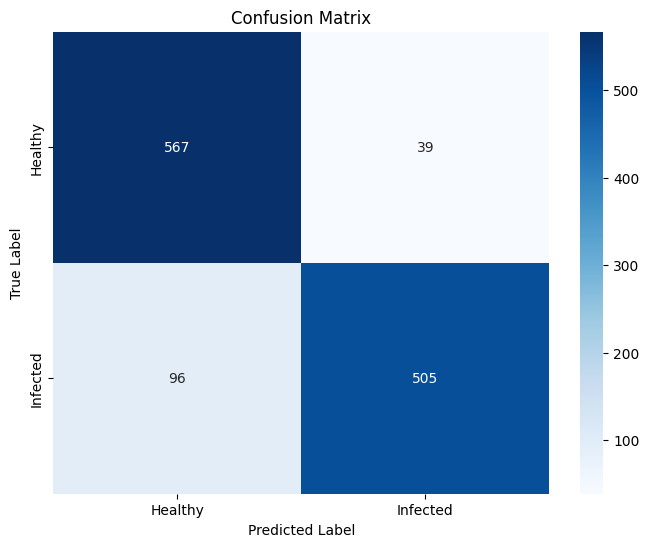

Generating ROC Curve and calculating AUC...


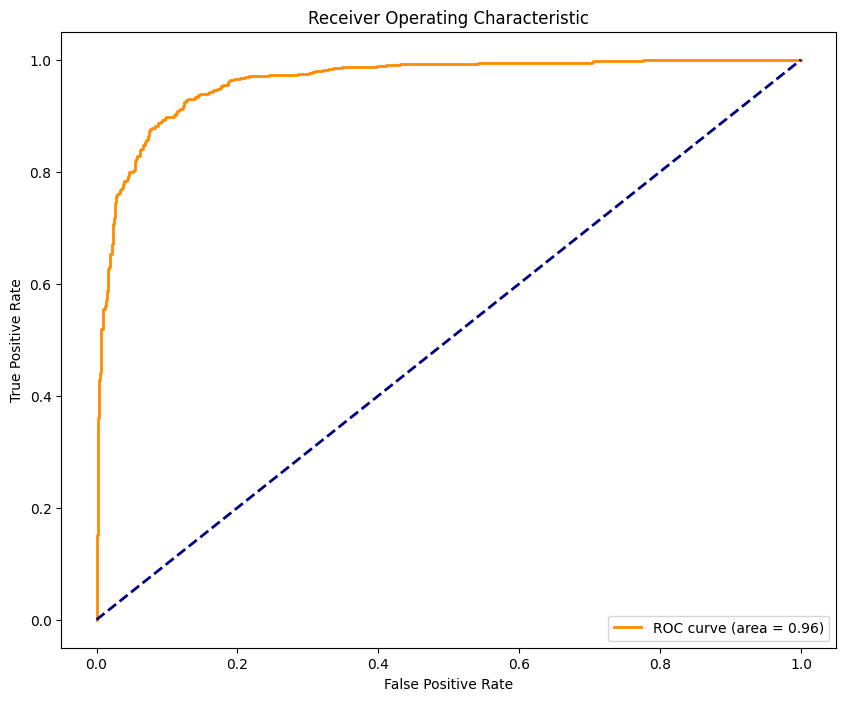

Evaluating on test data...
Predicting on test data...
Time taken to predict on test data: 10.64 seconds
Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.84      0.91      0.87       299
    Infected       0.90      0.82      0.86       289

    accuracy                           0.87       588
   macro avg       0.87      0.86      0.87       588
weighted avg       0.87      0.87      0.87       588

Confusion Matrix for Test Data:


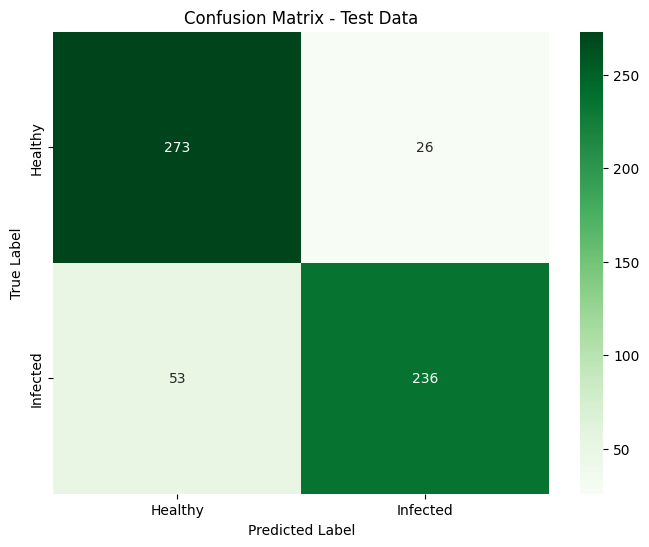

Generating ROC Curve and calculating AUC...


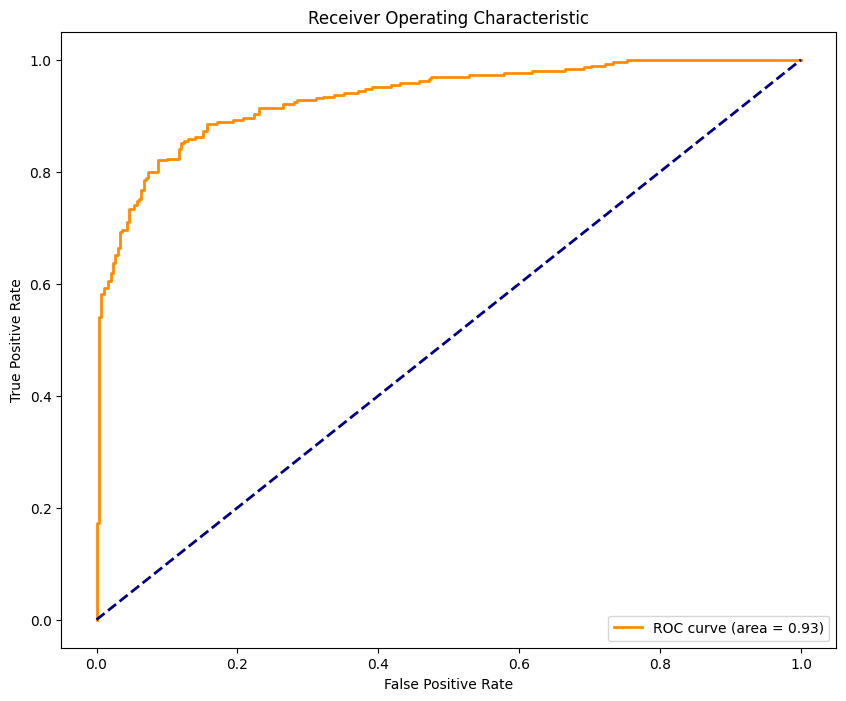

In [4]:
import joblib

# Save the trained SVM model
joblib.dump(svm, 'svm_model.joblib')
print("SVM model saved as 'svm_model.joblib'.")

# Validation predictions
print("Predicting on validation data...")
y_val_pred = svm.predict(X_val)
y_val_prob = svm.predict_proba(X_val)[:, 1]

# Classification report and confusion matrix
print('Classification Report for Validation Data:')
print(classification_report(y_val, y_val_pred, target_names=class_names))

print('Confusion Matrix for Validation Data:')
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
print("Generating ROC Curve and calculating AUC...")
lb = LabelBinarizer()
y_val_binarized = lb.fit_transform(y_val).ravel()
fpr, tpr, _ = roc_curve(y_val_binarized, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


print("Evaluating on test data...")
# Predicting on test data with timing
print("Predicting on test data...")
start_time = time.time()
y_test_pred = svm.predict(X_test)
y_test_prob = svm.predict_proba(X_test)[:, 1]
end_time = time.time()
prediction_time = end_time - start_time
print(f"Time taken to predict on test data: {prediction_time:.2f} seconds")

print('Classification Report for Test Data:')
print(classification_report(y_test, y_test_pred, target_names=class_names))

print('Confusion Matrix for Test Data:')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
print("Generating ROC Curve and calculating AUC...")
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test).ravel()
fpr, tpr, _ = roc_curve(y_test_binarized, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Loading the trained SVM model...
SVM model loaded successfully.

Evaluating on test data...
Predicting on test data...
Time taken to predict on test data: 4.88 seconds

Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.84      0.91      0.87       299
    Infected       0.90      0.82      0.86       289

    accuracy                           0.87       588
   macro avg       0.87      0.86      0.87       588
weighted avg       0.87      0.87      0.87       588

Confusion Matrix for Test Data:


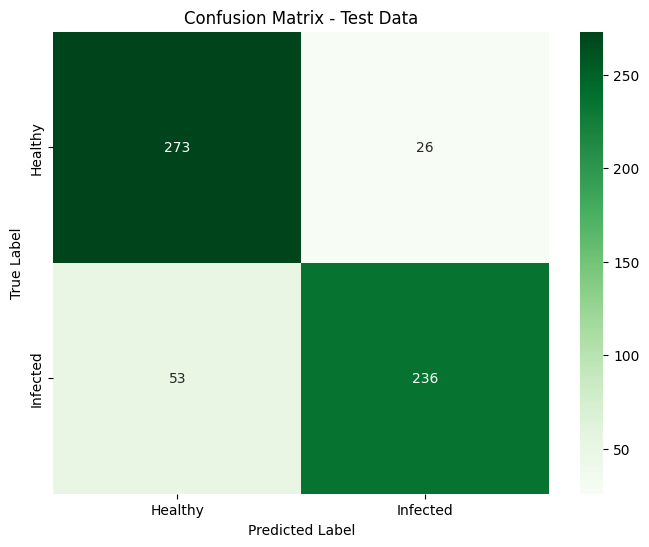

Generating ROC Curve and calculating AUC for Test Data...


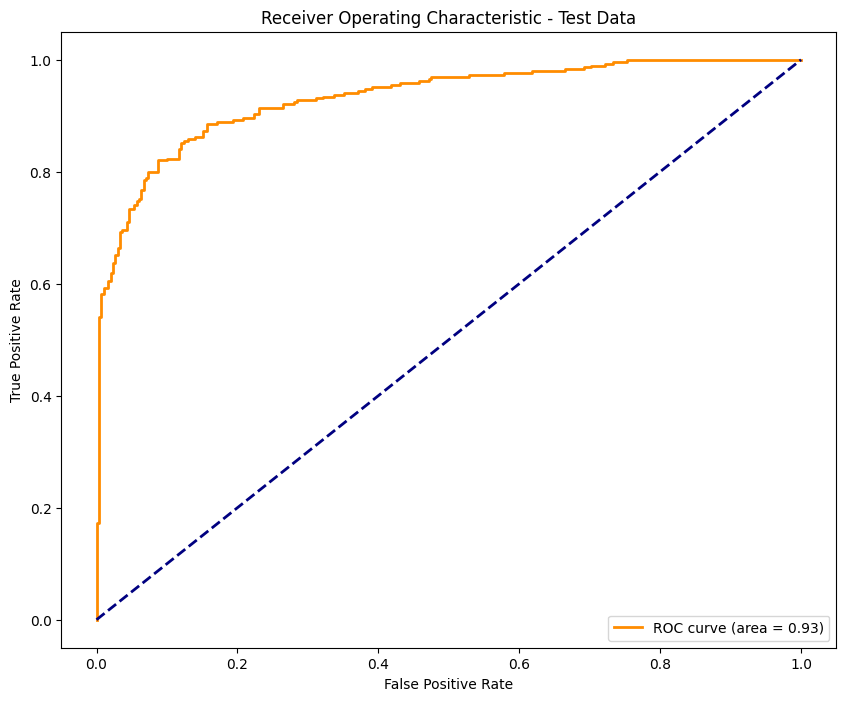

In [ ]:
import os
import time
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC


# Load the trained SVM model
print("Loading the trained SVM model...")
svm = joblib.load('svm_model.joblib')
print("SVM model loaded successfully.")

# Evaluating on Test Data
print("\nEvaluating on test data...")

# Predicting on test data with timing
print("Predicting on test data...")
start_time = time.time()
y_test_pred = svm.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Time taken to predict on test data: {prediction_time:.2f} seconds")


y_test_prob = svm.predict_proba(X_test)[:, 1]  # Adjust index if more than two classes

# Classification report and confusion matrix for Test Data
print('\nClassification Report for Test Data:')
print(classification_report(y_test, y_test_pred, target_names=class_names))

print('Confusion Matrix for Test Data:')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC for Test Data
print("Generating ROC Curve and calculating AUC for Test Data...")
y_test_binarized = lb.fit_transform(y_test)
if y_test_binarized.shape[1] == 1:
    y_test_binarized = np.hstack((1 - y_test_binarized, y_test_binarized))  # For binary classification

fpr_test, tpr_test, _ = roc_curve(y_test_binarized[:, 1], y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Data')
plt.legend(loc="lower right")
plt.show()


In [11]:
import tensorflow as tf
tf.__version__


'2.10.1'

### Final 2 CS and EH only

Classification Report for Validation Data:
              precision    recall  f1-score   support

     Healthy       0.84      0.94      0.89       606
    Infected       0.94      0.82      0.87       601

    accuracy                           0.88      1207
   macro avg       0.89      0.88      0.88      1207
weighted avg       0.89      0.88      0.88      1207

Confusion Matrix for Validation Data:


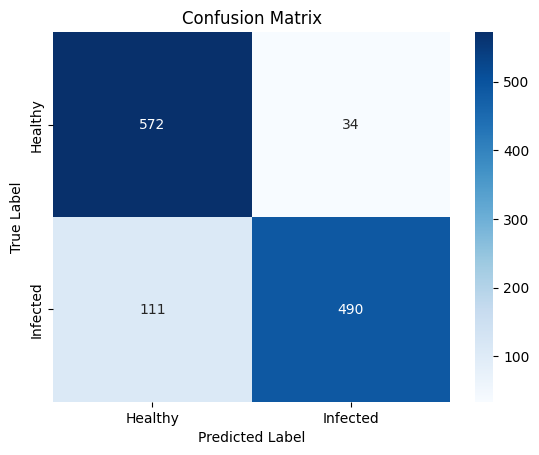

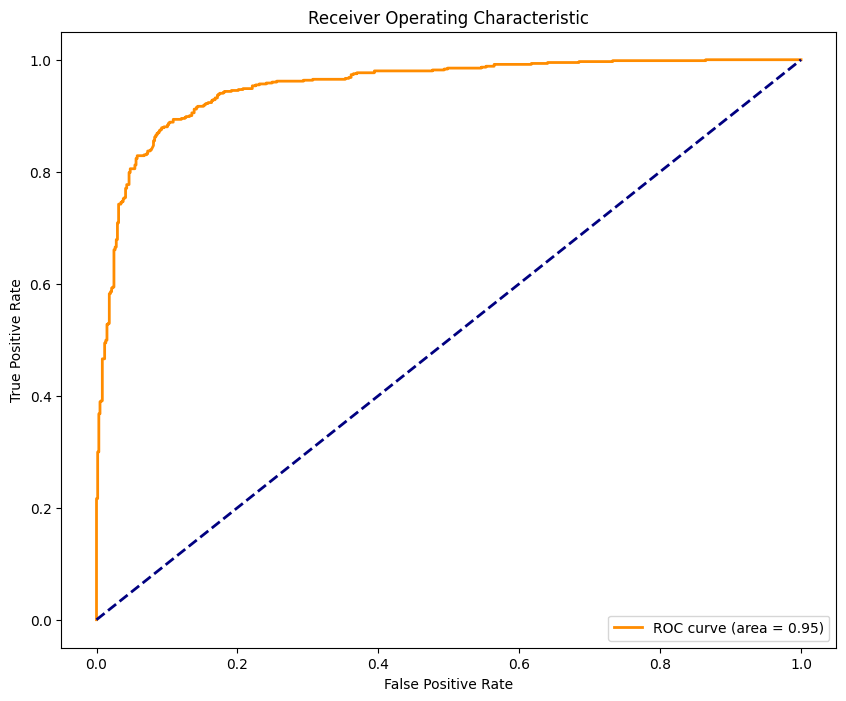

Predicting on test data...
Time taken to predict on test data: 3.84 seconds
Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.85      0.91      0.88       299
    Infected       0.90      0.83      0.87       289

    accuracy                           0.87       588
   macro avg       0.87      0.87      0.87       588
weighted avg       0.87      0.87      0.87       588

Confusion Matrix for Test Data:


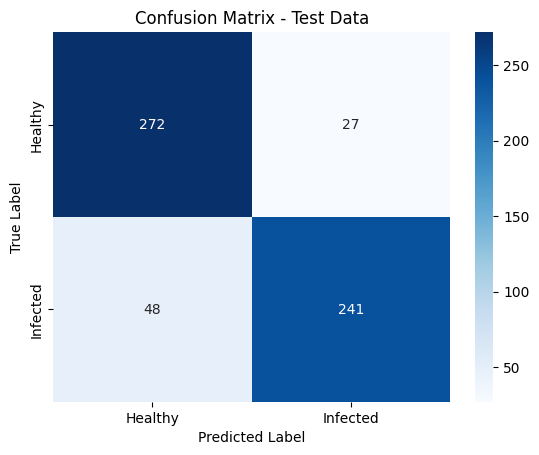

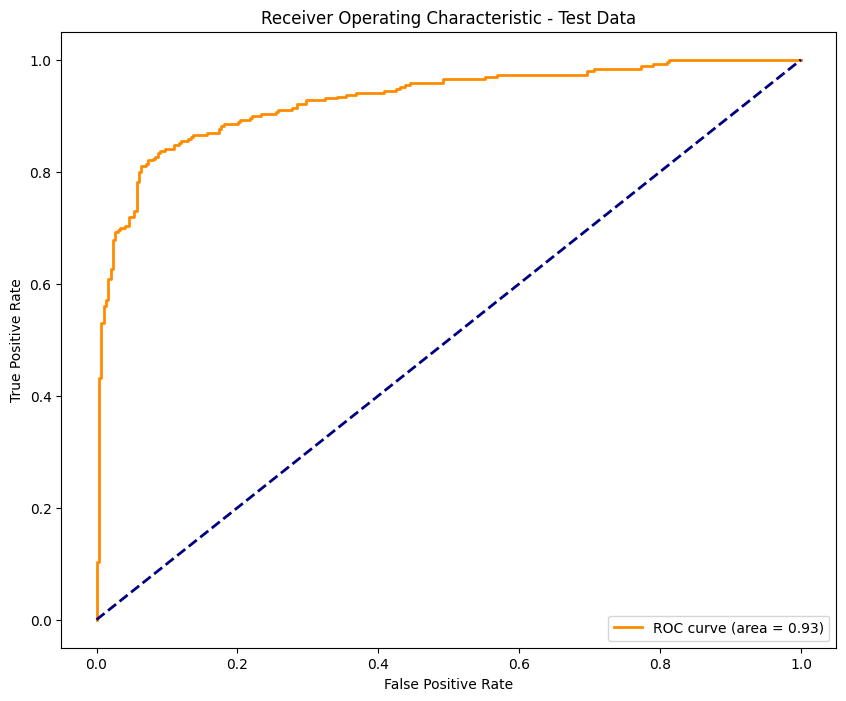

In [ ]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Function to extract features and load data
def extract_features_and_load_data(directory, img_height, img_width):
    images = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                features = extract_combined_features(img_array)
                images.append(features)
                labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

# Feature extraction functions
def extract_color_structure(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_edge_histogram(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    hist = cv2.calcHist([edges], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_piv(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    piv = np.var(gray_image)
    return piv

def extract_combined_features(image):
    color_structure = extract_color_structure(image)
    edge_histogram = extract_edge_histogram(image)
    combined_features = np.hstack([color_structure, edge_histogram])
    return combined_features

# Load and process data
X_train, y_train, class_names = extract_features_and_load_data(train_dir, img_height, img_width)
X_val, y_val, _ = extract_features_and_load_data(validation_dir, img_height, img_width)
X_test, y_test, _ = extract_features_and_load_data(test_dir, img_height, img_width)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)

# Validation predictions
y_val_pred = svm.predict(X_val)
y_val_prob = svm.predict_proba(X_val)[:, 1]

# Classification report and confusion matrix
print('Classification Report for Validation Data:')
print(classification_report(y_val, y_val_pred, target_names=class_names))
print('Confusion Matrix for Validation Data:')
conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC
lb = LabelBinarizer()
y_val_binarized = lb.fit_transform(y_val).ravel()
fpr, tpr, _ = roc_curve(y_val_binarized, y_val_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Test predictions
import time
print("Predicting on test data...")
start_time = time.time()
y_test_pred = svm.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Time taken to predict on test data: {prediction_time:.2f} seconds")

y_test_prob = svm.predict_proba(X_test)[:, 1]

# Classification report and confusion matrix for Test Data
print('Classification Report for Test Data:')
print(classification_report(y_test, y_test_pred, target_names=class_names))
print('Confusion Matrix for Test Data:')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve and AUC for Test Data
lb_test = LabelBinarizer()
y_test_binarized = lb_test.fit_transform(y_test).ravel()
fpr_test, tpr_test, _ = roc_curve(y_test_binarized, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Data')
plt.legend(loc="lower right")
plt.show()

# joblib.dump(svm, 'svm_model_CS_EH.joblib')

In [7]:
import time
import joblib

print("Predicting on test data...")
start_time = time.time()
y_test_pred = svm.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Time taken to predict on test data: {prediction_time:.2f} seconds")

Predicting on test data...
Time taken to predict on test data: 3.01 seconds


### Manual roc curve

Loading and processing training data...
Processing class 'Healthy' in directory: ./Tea_Leaf_Disease/train\Healthy
Found 14527 images in class 'Healthy'.


Processing class 'Infected' in directory: ./Tea_Leaf_Disease/train\Infected
Found 14406 images in class 'Infected'.
Extracted features from 28933 images in directory: ./Tea_Leaf_Disease/train
Training data loaded: 28933 samples.

Loading and processing validation data...
Processing class 'Healthy' in directory: ./Tea_Leaf_Disease/validation\Healthy
Found 606 images in class 'Healthy'.
Processing class 'Infected' in directory: ./Tea_Leaf_Disease/validation\Infected
Found 601 images in class 'Infected'.
Extracted features from 1207 images in directory: ./Tea_Leaf_Disease/validation
Validation data loaded: 1207 samples.

Loading and processing test data...
Processing class 'Healthy' in directory: ./Tea_Leaf_Disease/test\Healthy
Found 299 images in class 'Healthy'.
Processing class 'Infected' in directory: ./Tea_Leaf_Disease/test\Infected
Found 289 images in class 'Infected'.
Extracted features from 588 images in directory: ./Tea_Leaf_Disease/test
Test data loaded: 588 samples.

Normalizin

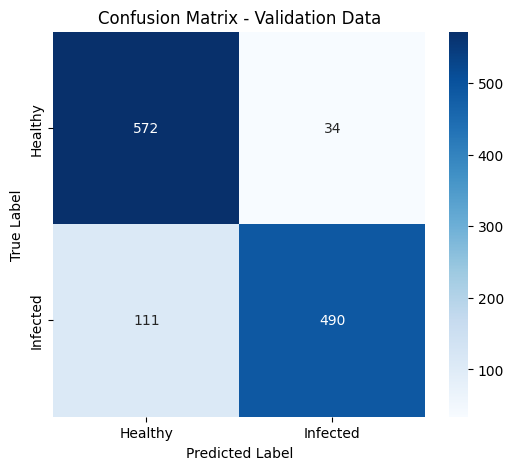

Calculating ROC Curve and AUC manually for Validation Data...
Manual AUC for Validation Data: 0.9528


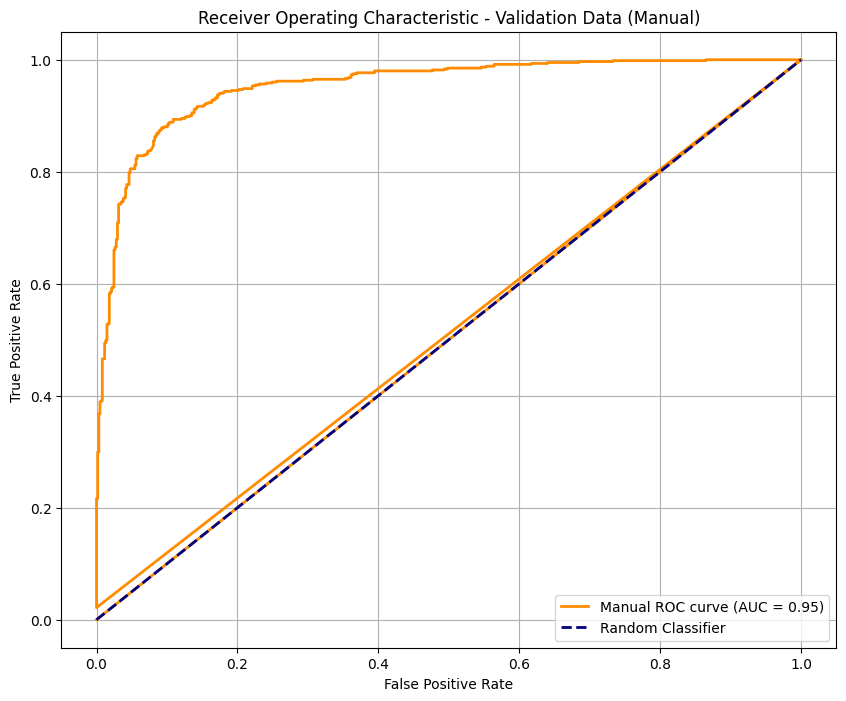


Predicting on test data...
Time taken to predict on test data: 4.64 seconds

Classification Report for Test Data:
              precision    recall  f1-score   support

     Healthy       0.85      0.91      0.88       299
    Infected       0.90      0.83      0.87       289

    accuracy                           0.87       588
   macro avg       0.87      0.87      0.87       588
weighted avg       0.87      0.87      0.87       588

Confusion Matrix for Test Data:


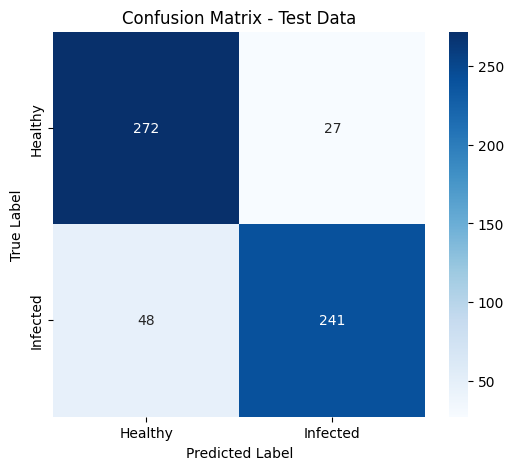

Calculating ROC Curve and AUC manually for Test Data...
Manual AUC for Test Data: 0.9287


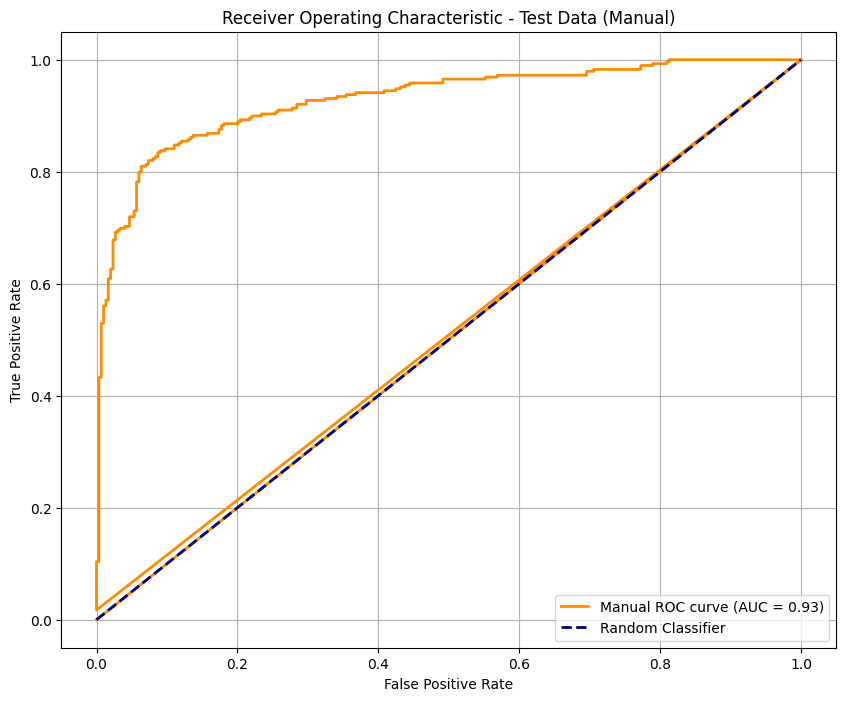

In [11]:
import os 
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Dataset directories
train_dir = './Tea_Leaf_Disease/train'
validation_dir = './Tea_Leaf_Disease/validation'
test_dir = './Tea_Leaf_Disease/test'

# Image size
img_height, img_width = 256, 256

# Feature extraction functions
def extract_color_structure(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_edge_histogram(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    hist = cv2.calcHist([edges], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_piv(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    piv = np.var(gray_image)
    return piv

def extract_combined_features(image):
    color_structure = extract_color_structure(image)
    edge_histogram = extract_edge_histogram(image)
    # Optionally include PIV or other features
    # piv = extract_piv(image)
    # combined_features = np.hstack([color_structure, edge_histogram, piv])
    combined_features = np.hstack([color_structure, edge_histogram])
    return combined_features

# Manual ROC and AUC computation functions
def compute_roc_curve(y_true, y_scores):
    """
    Manually computes the ROC curve coordinates.

    Parameters:
        y_true (array-like): True binary labels (0 or 1).
        y_scores (array-like): Predicted scores or probabilities for the positive class.

    Returns:
        fpr (list): False Positive Rates.
        tpr (list): True Positive Rates.
    """
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Sort scores and corresponding true labels in descending order of scores
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores_sorted = y_scores[desc_score_indices]
    y_true_sorted = y_true[desc_score_indices]

    # Get unique thresholds
    thresholds = np.unique(y_scores_sorted)

    # Initialize TPR and FPR lists
    tpr = []
    fpr = []

    # Total positive and negative instances
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)

    # Iterate through all thresholds
    for thresh in thresholds:
        # Predict positive if score >= threshold
        y_pred = (y_scores_sorted >= thresh).astype(int)

        # Calculate TP, FP
        TP = np.sum((y_pred == 1) & (y_true_sorted == 1))
        FP = np.sum((y_pred == 1) & (y_true_sorted == 0))

        # Calculate TPR and FPR
        current_tpr = TP / P if P != 0 else 0
        current_fpr = FP / N if N != 0 else 0

        tpr.append(current_tpr)
        fpr.append(current_fpr)

    # Append (0,0) and (1,1) to complete the ROC curve
    tpr = [0] + tpr + [1]
    fpr = [0] + fpr + [1]

    return fpr, tpr

def compute_auc(fpr, tpr):
    """
    Computes the Area Under the ROC Curve (AUC) using the Trapezoidal Rule.

    Parameters:
        fpr (list): False Positive Rates.
        tpr (list): True Positive Rates.

    Returns:
        auc_value (float): Computed AUC value.
    """
    fpr = np.array(fpr)
    tpr = np.array(tpr)

    # Sort FPR and corresponding TPR
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    # Compute AUC using the trapezoidal rule
    auc_value = 0.0
    for i in range(1, len(fpr_sorted)):
        auc_value += (fpr_sorted[i] - fpr_sorted[i-1]) * (tpr_sorted[i] + tpr_sorted[i-1]) / 2.0

    return auc_value

# Function to extract features and load data
def extract_features_and_load_data(directory, img_height, img_width):
    images = []
    labels = []
    class_names = ['Healthy', 'Infected']
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        print(f"Processing class '{class_name}' in directory: {class_path}")
        
        if not os.path.isdir(class_path):
            print(f"Directory {class_path} does not exist. Skipping...")
            continue
        
        img_files = os.listdir(class_path)
        print(f"Found {len(img_files)} images in class '{class_name}'.")
        
        for img_file in img_files:
            img_path = os.path.join(class_path, img_file)
            if not os.path.isfile(img_path):
                print(f"{img_path} is not a file. Skipping...")
                continue
            try:
                img = load_img(img_path, target_size=(img_height, img_width))
                img_array = img_to_array(img).astype("uint8")
                features = extract_combined_features(img_array)
                if features is not None:
                    images.append(features)
                    labels.append(class_indices[class_name])
            except Exception as e:
                print(f"Error loading or processing image {img_path}: {e}")
    
    if not images:
        print(f"No features extracted from directory: {directory}")
    else:
        print(f"Extracted features from {len(images)} images in directory: {directory}")
    
    return np.array(images), np.array(labels), class_names

# Load and process data
print("Loading and processing training data...")
X_train, y_train, class_names = extract_features_and_load_data(train_dir, img_height, img_width)
print(f"Training data loaded: {X_train.shape[0]} samples.")

print("\nLoading and processing validation data...")
X_val, y_val, _ = extract_features_and_load_data(validation_dir, img_height, img_width)
print(f"Validation data loaded: {X_val.shape[0]} samples.")

print("\nLoading and processing test data...")
X_test, y_test, _ = extract_features_and_load_data(test_dir, img_height, img_width)
print(f"Test data loaded: {X_test.shape[0]} samples.")

# Check if data is loaded
if X_train.size == 0:
    raise ValueError("Training data is empty. Please check the training directory and image files.")
if X_val.size == 0:
    raise ValueError("Validation data is empty. Please check the validation directory and image files.")
if X_test.size == 0:
    raise ValueError("Test data is empty. Please check the test directory and image files.")

# Normalize features
print("\nNormalizing features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("Feature normalization completed.")

# Train SVM
print("\nTraining SVM model...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
print("SVM training completed.")

# Validation predictions
print("\nMaking predictions on validation data...")
y_val_pred = svm.predict(X_val)
y_val_prob = svm.predict_proba(X_val)[:, 1]

# Classification report and confusion matrix for Validation Data
print('\nClassification Report for Validation Data:')
print(classification_report(y_val, y_val_pred, target_names=class_names))

print('Confusion Matrix for Validation Data:')
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Validation Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Manual ROC Curve and AUC Calculation for Validation Data
print("Calculating ROC Curve and AUC manually for Validation Data...")
fpr_val, tpr_val = compute_roc_curve(y_val, y_val_prob)
roc_auc_val = compute_auc(fpr_val, tpr_val)
print(f"Manual AUC for Validation Data: {roc_auc_val:.4f}")

# Plot Manual ROC Curve for Validation Data
plt.figure(figsize=(10, 8))
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'Manual ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Data (Manual)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Test predictions
import time
print("\nPredicting on test data...")
start_time = time.time()
y_test_pred = svm.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Time taken to predict on test data: {prediction_time:.2f} seconds")

y_test_prob = svm.predict_proba(X_test)[:, 1]

# Classification report and confusion matrix for Test Data
print('\nClassification Report for Test Data:')
print(classification_report(y_test, y_test_pred, target_names=class_names))

print('Confusion Matrix for Test Data:')
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Manual ROC Curve and AUC Calculation for Test Data
print("Calculating ROC Curve and AUC manually for Test Data...")
fpr_test, tpr_test = compute_roc_curve(y_test, y_test_prob)
roc_auc_test = compute_auc(fpr_test, tpr_test)
print(f"Manual AUC for Test Data: {roc_auc_test:.4f}")

# Plot Manual ROC Curve for Test Data
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Manual ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Data (Manual)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Optionally, save the trained model
# import joblib
# joblib.dump(svm, 'svm_model_CS_EH.joblib')


### Visualization of features

Feature Extraction Results:
Edge Histogram Shape: (256,)
Color Structure Shape: (512,)
PIV (Pixel Intensity Variance): 507.44
Color Histogram Shape: (512,)
DCT Features Shape: (64,)
Color Moments Shape: (9,)
Dominant Colors Shape: (9,)
Color Layout Shape: (192,)

--- Feature Arrays ---

Edge Histogram:
[0.99989223 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

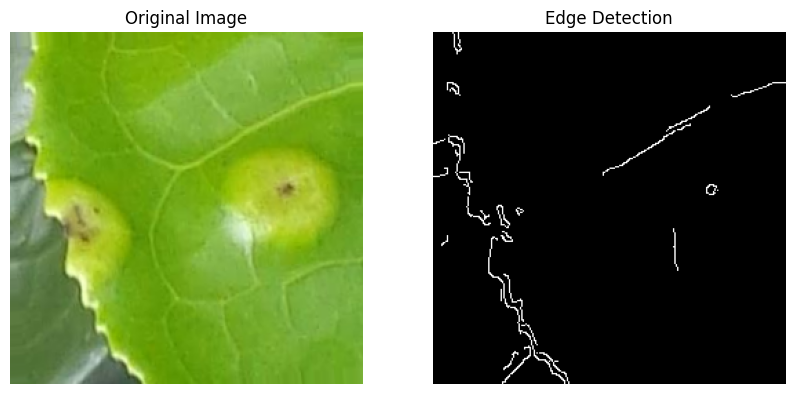

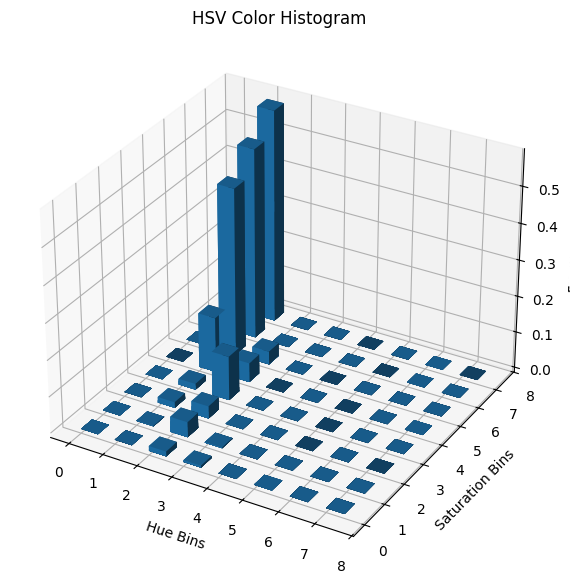

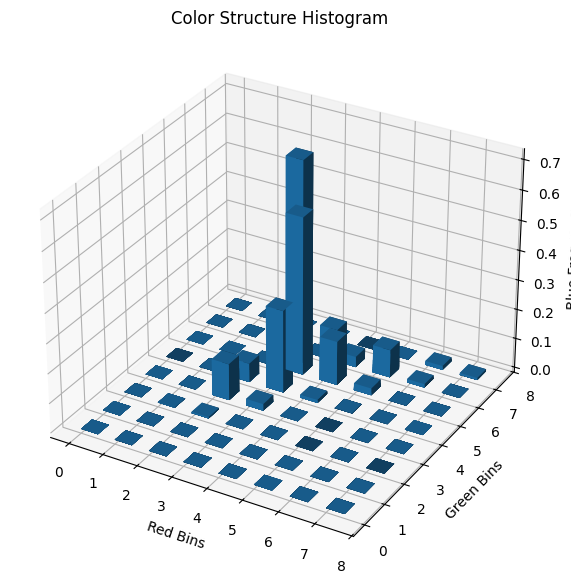

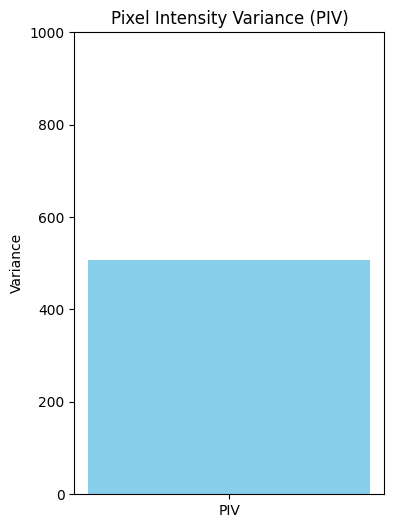

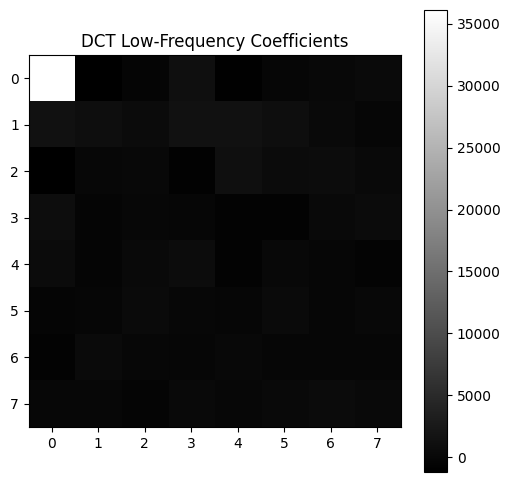

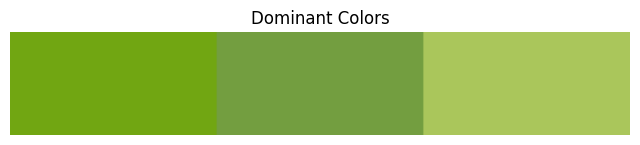

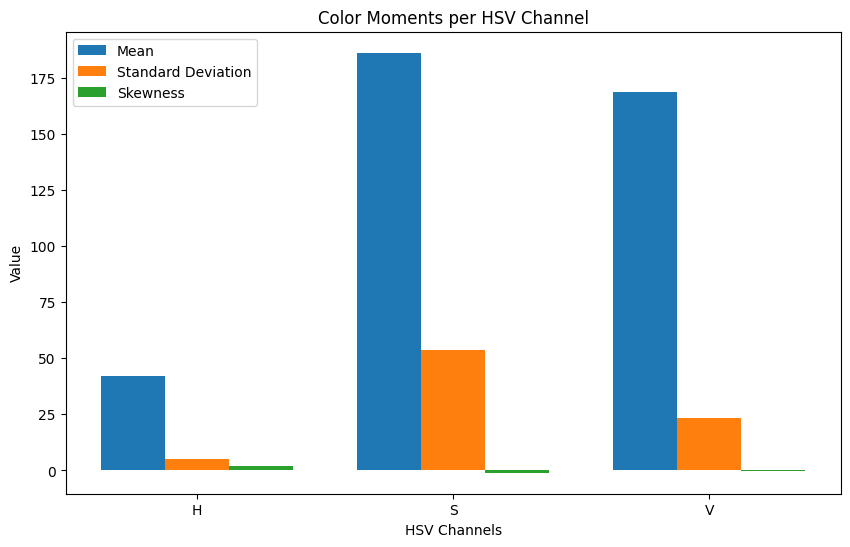

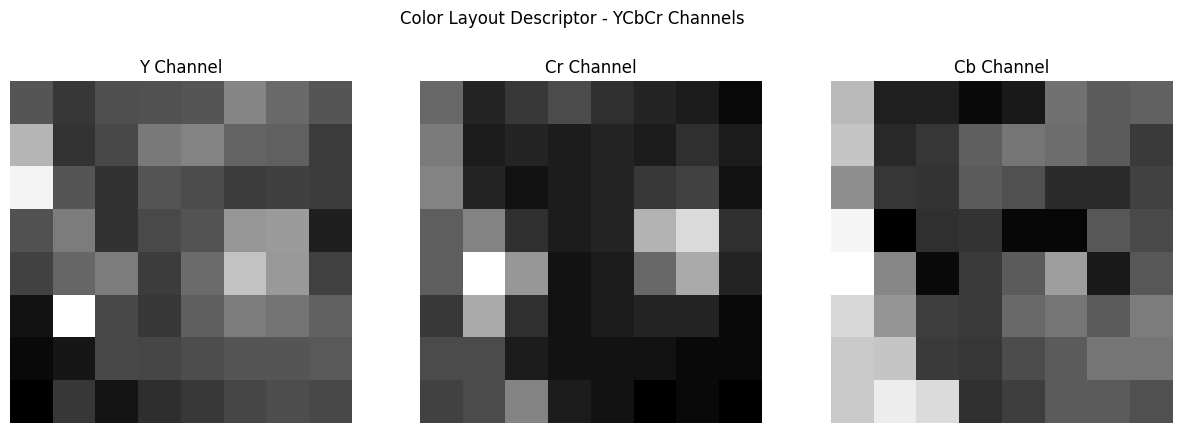

In [12]:
import os
import numpy as np
import cv2
from sklearn.cluster import KMeans
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns

# Feature extraction functions

# 1. Edge Histogram
def extract_edge_histogram(image, bins=256):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    hist = cv2.calcHist([edges], [0], None, [bins], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist, edges  # Returning edges for visualization

# 2. Color Structure
def extract_color_structure(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# 3. Pixel Intensity Variance (PIV)
def extract_piv(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    piv = np.var(gray_image)
    return piv

# 4. Color Histogram
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv_image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# 5. Discrete Cosine Transform (DCT) Features
def extract_dct_features(image, dct_size=8):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = np.float32(gray_image)
    dct = cv2.dct(gray_image)
    dct_low_freq = dct[:dct_size, :dct_size]
    dct_features = dct_low_freq.flatten()
    return dct_features, dct_low_freq  # Returning DCT low freq for visualization

# 6. Color Moments
def extract_color_moments(image):
    hsv_image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2HSV)
    channels = cv2.split(hsv_image)
    moments = []
    for channel in channels:
        channel = channel.flatten()
        mean = np.mean(channel)
        std = np.std(channel)
        sk = skew(channel)
        moments.extend([mean, std, sk])
    return np.array(moments)

# 7. Dominant Color
def extract_dominant_color(image, num_colors=3):
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    kmeans.fit(pixels)
    dominant_colors = kmeans.cluster_centers_.flatten()
    return dominant_colors, kmeans.cluster_centers_

# 8. Color Layout Descriptor
def extract_color_layout(image, grid_size=(8, 8)):
    h, w, _ = image.shape
    grid_h, grid_w = grid_size
    features = []
    resized = cv2.resize(image, (grid_w, grid_h))
    ycbcr_image = cv2.cvtColor(resized, cv2.COLOR_RGB2YCrCb)
    for i in range(3):  # Y, Cr, Cb
        channel = ycbcr_image[:, :, i]
        features.extend(channel.flatten())
    return np.array(features), ycbcr_image  # Returning YCbCr image for visualization

# Visualization functions

def plot_edge_detection(original, edges):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')
    plt.show()

def plot_color_histogram(hist, bins=(8,8,8), title='HSV Color Histogram'):
    # Reshape histogram to 3D for plotting
    if len(hist) == np.prod(bins):  # e.g., 8x8x8
        hist = hist.reshape(bins)
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        xpos, ypos, zpos = np.indices(bins)
        xpos = xpos.flatten()
        ypos = ypos.flatten()
        zpos = np.zeros_like(zpos.flatten())
        dx = dy = dz = 0.5  # Size of the bars
        ax.bar3d(xpos, ypos, zpos, dx, dy, hist.flatten(), shade=True)
        ax.set_title(title)
        ax.set_xlabel('Hue Bins')
        ax.set_ylabel('Saturation Bins')
        ax.set_zlabel('Frequency')
        plt.show()
    else:
        plt.figure()
        plt.plot(hist)
        plt.title(title)
        plt.xlabel('Bins')
        plt.ylabel('Frequency')
        plt.show()

def plot_dct(dct_low_freq):
    plt.figure(figsize=(6,6))
    plt.imshow(dct_low_freq, cmap='gray')
    plt.title('DCT Low-Frequency Coefficients')
    plt.colorbar()
    plt.show()

def plot_dominant_colors(cluster_centers):
    # Convert colors from float to integer
    colors = cluster_centers.astype(int)
    # Create a bar chart
    bar = np.zeros((50, 300, 3), dtype='uint8')
    step = 300 // len(colors)
    for i, color in enumerate(colors):
        start = i * step
        end = (i + 1) * step
        bar[:, start:end, :] = color
    plt.figure(figsize=(8, 2))
    plt.imshow(bar)
    plt.title('Dominant Colors')
    plt.axis('off')
    plt.show()

def plot_color_layout(ycbcr_image, grid_size=(8,8)):
    # Display Y, Cr, Cb channels
    plt.figure(figsize=(15, 5))
    titles = ['Y Channel', 'Cr Channel', 'Cb Channel']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(ycbcr_image[:, :, i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.suptitle('Color Layout Descriptor - YCbCr Channels')
    plt.show()

def plot_color_structure(hist, bins=(8,8,8), title='Color Structure Histogram'):
    # Similar to color histogram but in RGB
    if len(hist) == np.prod(bins):
        hist = hist.reshape(bins)
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        xpos, ypos, zpos = np.indices(bins)
        xpos = xpos.flatten()
        ypos = ypos.flatten()
        zpos = np.zeros_like(zpos.flatten())
        dx = dy = dz = 0.5
        ax.bar3d(xpos, ypos, zpos, dx, dy, hist.flatten(), shade=True)
        ax.set_title(title)
        ax.set_xlabel('Red Bins')
        ax.set_ylabel('Green Bins')
        ax.set_zlabel('Blue Frequency')
        plt.show()
    else:
        plt.figure()
        plt.plot(hist)
        plt.title(title)
        plt.xlabel('Bins')
        plt.ylabel('Frequency')
        plt.show()

def plot_color_moments(color_moments):
    # Plot the mean, std, and skewness for each channel
    channels = ['H', 'S', 'V']
    mean = color_moments[0::3]
    std = color_moments[1::3]
    skewness = color_moments[2::3]
    
    x = np.arange(len(channels))
    width = 0.25
    
    plt.figure(figsize=(10,6))
    plt.bar(x - width, mean, width, label='Mean')
    plt.bar(x, std, width, label='Standard Deviation')
    plt.bar(x + width, skewness, width, label='Skewness')
    
    plt.xlabel('HSV Channels')
    plt.ylabel('Value')
    plt.title('Color Moments per HSV Channel')
    plt.xticks(x, channels)
    plt.legend()
    plt.show()

def plot_piv(piv):
    # Since PIV is a single scalar value, visualize it as part of a bar chart
    plt.figure(figsize=(4,6))
    plt.bar(['PIV'], [piv], color='skyblue')
    plt.ylabel('Variance')
    plt.title('Pixel Intensity Variance (PIV)')
    plt.ylim(0, max(piv * 1.2, 1000))  # Adjust y-limit for better visualization
    plt.show()

# Main function to extract and visualize features from a single image

def process_single_image(image_path):
    # Load image
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Extract features
    edge_hist, edges = extract_edge_histogram(original)
    color_structure = extract_color_structure(original)
    piv = extract_piv(original)
    color_hist = extract_color_histogram(original)
    dct_features, dct_low_freq = extract_dct_features(original)
    color_moments = extract_color_moments(original)
    dominant_colors, cluster_centers = extract_dominant_color(original)
    color_layout, ycbcr_image = extract_color_layout(original)
    
    # Print extracted feature shapes
    print("Feature Extraction Results:")
    print(f"Edge Histogram Shape: {edge_hist.shape}")
    print(f"Color Structure Shape: {color_structure.shape}")
    print(f"PIV (Pixel Intensity Variance): {piv:.2f}")
    print(f"Color Histogram Shape: {color_hist.shape}")
    print(f"DCT Features Shape: {dct_features.shape}")
    print(f"Color Moments Shape: {color_moments.shape}")
    print(f"Dominant Colors Shape: {dominant_colors.shape}")
    print(f"Color Layout Shape: {color_layout.shape}")
    
    # Print the actual feature arrays
    print("\n--- Feature Arrays ---\n")
    
    # 1. Edge Histogram
    print("Edge Histogram:")
    print(edge_hist)
    print("\n")
    
    # 2. Color Structure
    print("Color Structure:")
    print(color_structure)
    print("\n")
    
    # 3. Pixel Intensity Variance (PIV)
    print("Pixel Intensity Variance (PIV):")
    print(piv)
    print("\n")
    
    # 4. Color Histogram
    print("Color Histogram:")
    print(color_hist)
    print("\n")
    
    # 5. DCT Features
    print("DCT Features:")
    print(dct_features)
    print("\n")
    
    # 6. Color Moments
    print("Color Moments:")
    print(color_moments)
    print("\n")
    
    # 7. Dominant Colors
    print("Dominant Colors:")
    print(dominant_colors)
    print("\n")
    
    # 8. Color Layout
    print("Color Layout:")
    print(color_layout)
    print("\n")
    
    # Visualizations
    plot_edge_detection(original, edges)
    plot_color_histogram(color_hist, bins=(8,8,8), title='HSV Color Histogram')
    plot_color_structure(color_structure, bins=(8,8,8), title='Color Structure Histogram')
    plot_piv(piv)
    plot_dct(dct_low_freq)
    plot_dominant_colors(cluster_centers)
    plot_color_moments(color_moments)
    plot_color_layout(ycbcr_image, grid_size=(8,8))
    
    # Optionally, return all features
    features = {
        'edge_histogram': edge_hist,
        'color_structure': color_structure,
        'piv': piv,
        'color_histogram': color_hist,
        'dct_features': dct_features,
        'color_moments': color_moments,
        'dominant_colors': dominant_colors,
        'color_layout': color_layout
    }
    
    return features

# Example usage
if __name__ == "__main__":
    # Path to the image you want to process
    image_path = './Tea_Leaf_Disease/train/Infected/1-159_1024_1024_512_512_0_0_0_6678.png'  
    
    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image file {image_path} does not exist. Please provide a valid path.")
    else:
        features = process_single_image(image_path)
